In [0]:
# Import relevant modules

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as t_data
import torchvision.datasets as datasets
from torchvision import transforms

In [3]:
# Load the MNIST Dataset

data_transforms = transforms.Compose([transforms.ToTensor()])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=data_transforms)



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
# Define training batch size

batch_size=100
dataloader_mnist_train = t_data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)

In [0]:
# Function to generate random noise (to be used as input to the Generator Network)

def noise(batch_size):
    return torch.randn(batch_size,100)

In [0]:
# Define the generator class

class generator(nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self, n_features, n_out):
        super(generator, self).__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [0]:
# Define the discriminator class

class discriminator(nn.Module):
    
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self, n_features, n_out):
        super(discriminator, self).__init__()
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [0]:
# Function to display images of real/generated images

def plot_img(array, ax, i, j):
    array = array.detach()
    array = array.reshape(28,28)
    
    ax[i, j].imshow(array,cmap='binary')


In [0]:
# Create the discriminator & generator objects
dis = discriminator(784, 1)
gen = generator(100, 784)

# Define Loss functions & Optimizers
criterion_d = nn.BCELoss()
optimizer_d = optim.SGD(dis.parameters(), lr=0.001, momentum=0.9)

criterion_g = nn.BCELoss()
optimizer_g = optim.SGD(gen.parameters(), lr=0.001, momentum=0.9)

In [0]:
# Function to train the discriminator

def train_discriminator(optimizer, loss, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = dis(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, Variable(torch.ones(N, 1)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = dis(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, Variable(torch.zeros(N, 1)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [0]:
# Function to train the generator

def train_generator(optimizer, loss, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = dis(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, Variable(torch.ones(N, 1)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [0]:
# Generate noise samples to act as validation data (to view at the end of every epoch)

num_test_samples = 16
validation_noise = noise(num_test_samples)

In [0]:
# To store generator & discriminator errors (will be plotted later)

g_err = []
d_err = []

In [14]:
print(len(dataloader_mnist_train))

600


Epoch: 0
	Batch: 1	Discriminator Error: 1.391677	Generator Error: 0.669039
	Batch: 100	Discriminator Error: 1.234424	Generator Error: 0.695261
	Batch: 200	Discriminator Error: 0.678499	Generator Error: 0.833245
	Batch: 300	Discriminator Error: 0.980941	Generator Error: 0.799718
	Batch: 400	Discriminator Error: 1.416133	Generator Error: 1.047948
	Batch: 500	Discriminator Error: 0.821875	Generator Error: 1.501924
	Batch: 600	Discriminator Error: 0.586145	Generator Error: 2.598016


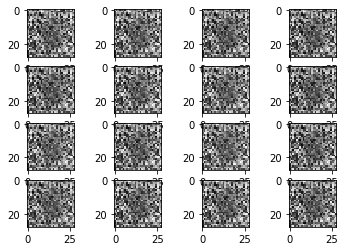

Epoch: 1
	Batch: 1	Discriminator Error: 0.644557	Generator Error: 2.661061
	Batch: 100	Discriminator Error: 1.115737	Generator Error: 3.117379
	Batch: 200	Discriminator Error: 1.367278	Generator Error: 0.620427
	Batch: 300	Discriminator Error: 1.263801	Generator Error: 1.024092
	Batch: 400	Discriminator Error: 1.195904	Generator Error: 1.064599
	Batch: 500	Discriminator Error: 1.351858	Generator Error: 1.136621
	Batch: 600	Discriminator Error: 0.374181	Generator Error: 1.415843


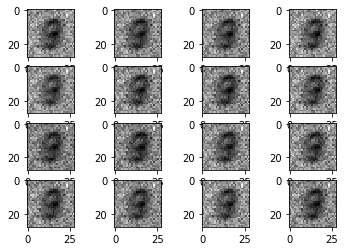

Epoch: 2
	Batch: 1	Discriminator Error: 0.390043	Generator Error: 1.404367
	Batch: 100	Discriminator Error: 0.323213	Generator Error: 2.465167
	Batch: 200	Discriminator Error: 0.386427	Generator Error: 2.955252
	Batch: 300	Discriminator Error: 0.993510	Generator Error: 2.453840
	Batch: 400	Discriminator Error: 0.210225	Generator Error: 2.753381
	Batch: 500	Discriminator Error: 5.372680	Generator Error: 4.771772
	Batch: 600	Discriminator Error: 0.712700	Generator Error: 1.438738


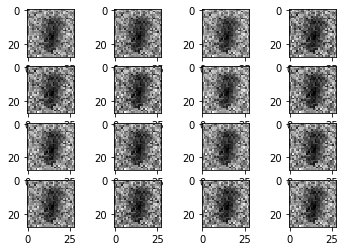

Epoch: 3
	Batch: 1	Discriminator Error: 0.790102	Generator Error: 1.418755
	Batch: 100	Discriminator Error: 0.953388	Generator Error: 1.305183
	Batch: 200	Discriminator Error: 0.365025	Generator Error: 2.013990
	Batch: 300	Discriminator Error: 0.313781	Generator Error: 2.184772
	Batch: 400	Discriminator Error: 0.287857	Generator Error: 2.897826
	Batch: 500	Discriminator Error: 0.975660	Generator Error: 3.125425
	Batch: 600	Discriminator Error: 1.184793	Generator Error: 1.558805


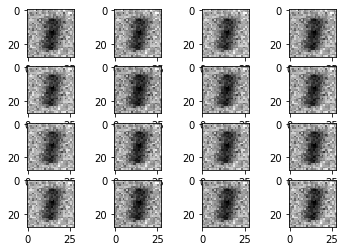

Epoch: 4
	Batch: 1	Discriminator Error: 1.096986	Generator Error: 1.534066
	Batch: 100	Discriminator Error: 0.175497	Generator Error: 3.140226
	Batch: 200	Discriminator Error: 0.167883	Generator Error: 3.432909
	Batch: 300	Discriminator Error: 0.313415	Generator Error: 2.922969
	Batch: 400	Discriminator Error: 0.388565	Generator Error: 2.833287
	Batch: 500	Discriminator Error: 0.218027	Generator Error: 2.579628
	Batch: 600	Discriminator Error: 0.169711	Generator Error: 3.450209


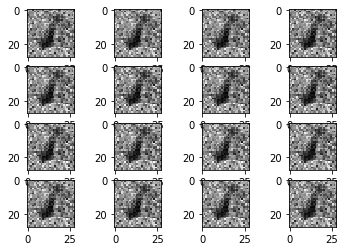

Epoch: 5
	Batch: 1	Discriminator Error: 0.203822	Generator Error: 3.478379
	Batch: 100	Discriminator Error: 1.964651	Generator Error: 1.953740
	Batch: 200	Discriminator Error: 0.716742	Generator Error: 1.151349
	Batch: 300	Discriminator Error: 0.426883	Generator Error: 1.560297
	Batch: 400	Discriminator Error: 0.310764	Generator Error: 2.673222
	Batch: 500	Discriminator Error: 0.079389	Generator Error: 3.816637
	Batch: 600	Discriminator Error: 0.814557	Generator Error: 2.097800


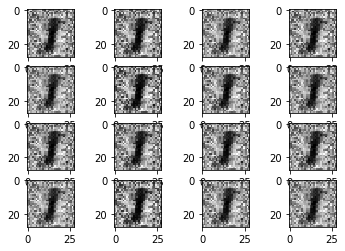

Epoch: 6
	Batch: 1	Discriminator Error: 0.818317	Generator Error: 2.031843
	Batch: 100	Discriminator Error: 0.643177	Generator Error: 1.879338
	Batch: 200	Discriminator Error: 0.261208	Generator Error: 2.047471
	Batch: 300	Discriminator Error: 0.261045	Generator Error: 2.558125
	Batch: 400	Discriminator Error: 0.737606	Generator Error: 2.938270
	Batch: 500	Discriminator Error: 0.638486	Generator Error: 3.315393
	Batch: 600	Discriminator Error: 0.204902	Generator Error: 2.631539


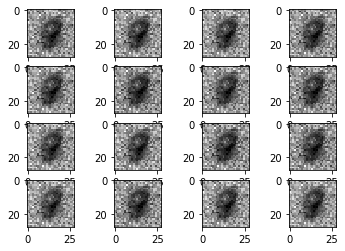

Epoch: 7
	Batch: 1	Discriminator Error: 0.216606	Generator Error: 2.617155
	Batch: 100	Discriminator Error: 0.292595	Generator Error: 2.572909
	Batch: 200	Discriminator Error: 0.162011	Generator Error: 3.247509
	Batch: 300	Discriminator Error: 0.906851	Generator Error: 3.930534
	Batch: 400	Discriminator Error: 0.621203	Generator Error: 2.631428
	Batch: 500	Discriminator Error: 0.248973	Generator Error: 2.873213
	Batch: 600	Discriminator Error: 0.345622	Generator Error: 2.074938


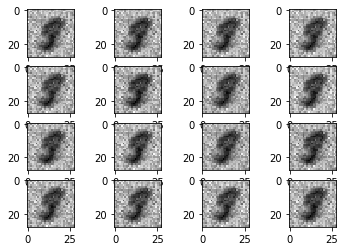

Epoch: 8
	Batch: 1	Discriminator Error: 0.287670	Generator Error: 2.069533
	Batch: 100	Discriminator Error: 0.201589	Generator Error: 3.170885
	Batch: 200	Discriminator Error: 0.082390	Generator Error: 4.206553
	Batch: 300	Discriminator Error: 1.266958	Generator Error: 2.820142
	Batch: 400	Discriminator Error: 0.433877	Generator Error: 3.405421
	Batch: 500	Discriminator Error: 0.497700	Generator Error: 2.578382
	Batch: 600	Discriminator Error: 0.290639	Generator Error: 2.464627


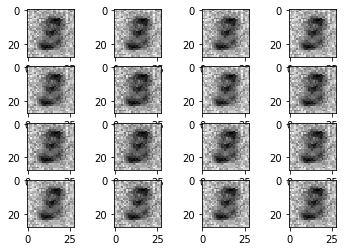

Epoch: 9
	Batch: 1	Discriminator Error: 0.255142	Generator Error: 2.533658
	Batch: 100	Discriminator Error: 0.136736	Generator Error: 2.891095
	Batch: 200	Discriminator Error: 0.807719	Generator Error: 5.067408
	Batch: 300	Discriminator Error: 0.949464	Generator Error: 1.531750
	Batch: 400	Discriminator Error: 0.516411	Generator Error: 2.138422
	Batch: 500	Discriminator Error: 0.145782	Generator Error: 2.794012
	Batch: 600	Discriminator Error: 0.175827	Generator Error: 2.925999


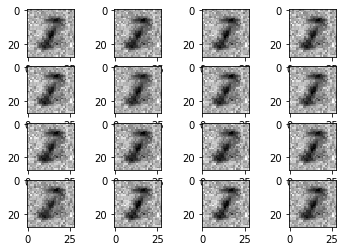

Epoch: 10
	Batch: 1	Discriminator Error: 0.154802	Generator Error: 2.773975
	Batch: 100	Discriminator Error: 0.084739	Generator Error: 3.071271
	Batch: 200	Discriminator Error: 0.824247	Generator Error: 4.256856
	Batch: 300	Discriminator Error: 0.344201	Generator Error: 3.169846
	Batch: 400	Discriminator Error: 0.140288	Generator Error: 3.155610
	Batch: 500	Discriminator Error: 0.166386	Generator Error: 3.150134
	Batch: 600	Discriminator Error: 0.350897	Generator Error: 3.470072


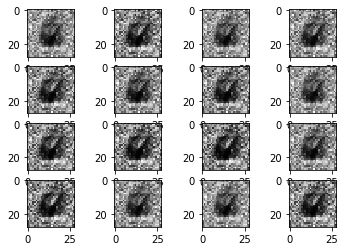

Epoch: 11
	Batch: 1	Discriminator Error: 0.347380	Generator Error: 3.230674
	Batch: 100	Discriminator Error: 0.178451	Generator Error: 3.500267
	Batch: 200	Discriminator Error: 0.384671	Generator Error: 2.841437
	Batch: 300	Discriminator Error: 0.213952	Generator Error: 3.153050
	Batch: 400	Discriminator Error: 0.098659	Generator Error: 3.583606
	Batch: 500	Discriminator Error: 0.161811	Generator Error: 3.737251
	Batch: 600	Discriminator Error: 1.221179	Generator Error: 2.588739


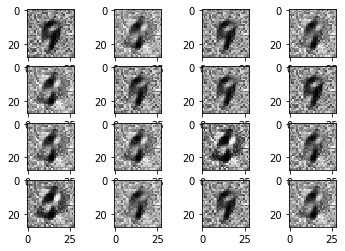

Epoch: 12
	Batch: 1	Discriminator Error: 1.148421	Generator Error: 2.572826
	Batch: 100	Discriminator Error: 0.429741	Generator Error: 2.588704
	Batch: 200	Discriminator Error: 0.402062	Generator Error: 1.867223
	Batch: 300	Discriminator Error: 0.303983	Generator Error: 2.505624
	Batch: 400	Discriminator Error: 0.359191	Generator Error: 3.521002
	Batch: 500	Discriminator Error: 0.220751	Generator Error: 3.613589
	Batch: 600	Discriminator Error: 0.401329	Generator Error: 3.463915


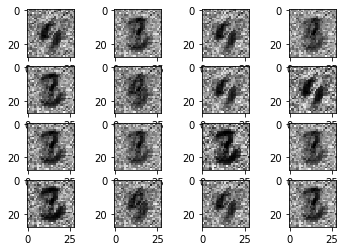

Epoch: 13
	Batch: 1	Discriminator Error: 0.285229	Generator Error: 3.503679
	Batch: 100	Discriminator Error: 0.317201	Generator Error: 3.783729
	Batch: 200	Discriminator Error: 0.135626	Generator Error: 4.015769
	Batch: 300	Discriminator Error: 0.304284	Generator Error: 3.522780
	Batch: 400	Discriminator Error: 0.455398	Generator Error: 3.726128
	Batch: 500	Discriminator Error: 0.404345	Generator Error: 3.021944
	Batch: 600	Discriminator Error: 0.279833	Generator Error: 2.930740


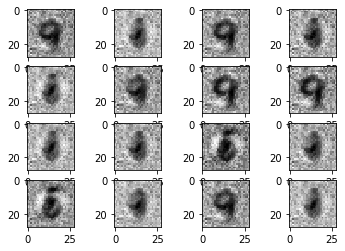

Epoch: 14
	Batch: 1	Discriminator Error: 0.285658	Generator Error: 3.130989
	Batch: 100	Discriminator Error: 0.338071	Generator Error: 2.754834
	Batch: 200	Discriminator Error: 0.326173	Generator Error: 3.052966
	Batch: 300	Discriminator Error: 0.691874	Generator Error: 3.690541
	Batch: 400	Discriminator Error: 0.426929	Generator Error: 4.358581
	Batch: 500	Discriminator Error: 0.321168	Generator Error: 2.412426
	Batch: 600	Discriminator Error: 0.158621	Generator Error: 3.464950


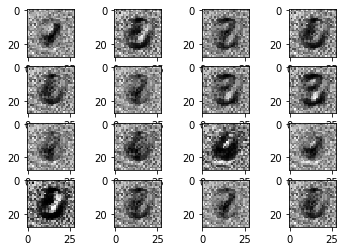

Epoch: 15
	Batch: 1	Discriminator Error: 0.159606	Generator Error: 3.588776
	Batch: 100	Discriminator Error: 0.450500	Generator Error: 3.309985
	Batch: 200	Discriminator Error: 0.289403	Generator Error: 2.784428
	Batch: 300	Discriminator Error: 0.364772	Generator Error: 3.725108
	Batch: 400	Discriminator Error: 0.194013	Generator Error: 3.563715
	Batch: 500	Discriminator Error: 0.274382	Generator Error: 3.970914
	Batch: 600	Discriminator Error: 0.166636	Generator Error: 4.520889


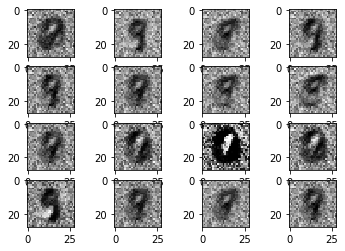

Epoch: 16
	Batch: 1	Discriminator Error: 0.180536	Generator Error: 4.461585
	Batch: 100	Discriminator Error: 0.182190	Generator Error: 4.193058
	Batch: 200	Discriminator Error: 0.352977	Generator Error: 3.806520
	Batch: 300	Discriminator Error: 0.288686	Generator Error: 3.706675
	Batch: 400	Discriminator Error: 0.158333	Generator Error: 4.433348
	Batch: 500	Discriminator Error: 0.296989	Generator Error: 3.583375
	Batch: 600	Discriminator Error: 0.246515	Generator Error: 4.179691


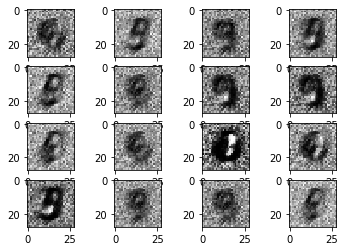

Epoch: 17
	Batch: 1	Discriminator Error: 0.202317	Generator Error: 4.342122
	Batch: 100	Discriminator Error: 0.222890	Generator Error: 4.716486
	Batch: 200	Discriminator Error: 0.228427	Generator Error: 3.706502
	Batch: 300	Discriminator Error: 0.373802	Generator Error: 4.476597
	Batch: 400	Discriminator Error: 0.408500	Generator Error: 4.939498
	Batch: 500	Discriminator Error: 0.267469	Generator Error: 4.119735
	Batch: 600	Discriminator Error: 0.179019	Generator Error: 4.050577


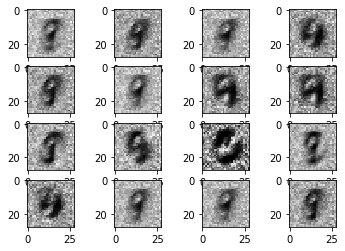

Epoch: 18
	Batch: 1	Discriminator Error: 0.188764	Generator Error: 4.072627
	Batch: 100	Discriminator Error: 0.268281	Generator Error: 3.388601
	Batch: 200	Discriminator Error: 0.345154	Generator Error: 4.130971
	Batch: 300	Discriminator Error: 0.246036	Generator Error: 4.303281
	Batch: 400	Discriminator Error: 0.361632	Generator Error: 4.524453
	Batch: 500	Discriminator Error: 0.394952	Generator Error: 3.475978
	Batch: 600	Discriminator Error: 0.236982	Generator Error: 4.243894


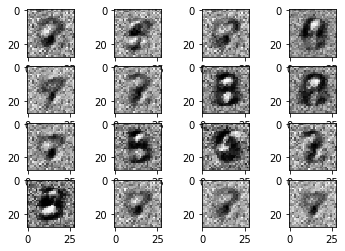

Epoch: 19
	Batch: 1	Discriminator Error: 0.154706	Generator Error: 4.149443
	Batch: 100	Discriminator Error: 0.356975	Generator Error: 3.378505
	Batch: 200	Discriminator Error: 0.179858	Generator Error: 4.284012
	Batch: 300	Discriminator Error: 0.243772	Generator Error: 3.779373
	Batch: 400	Discriminator Error: 0.307054	Generator Error: 4.429190
	Batch: 500	Discriminator Error: 0.237672	Generator Error: 3.865689
	Batch: 600	Discriminator Error: 0.230531	Generator Error: 4.657991


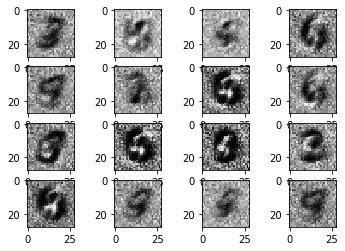

Epoch: 20
	Batch: 1	Discriminator Error: 0.217260	Generator Error: 4.546144
	Batch: 100	Discriminator Error: 0.379282	Generator Error: 3.432694
	Batch: 200	Discriminator Error: 0.235831	Generator Error: 4.228262
	Batch: 300	Discriminator Error: 0.305468	Generator Error: 5.109785
	Batch: 400	Discriminator Error: 0.300020	Generator Error: 3.813051
	Batch: 500	Discriminator Error: 0.209950	Generator Error: 4.629448
	Batch: 600	Discriminator Error: 0.178684	Generator Error: 5.640718


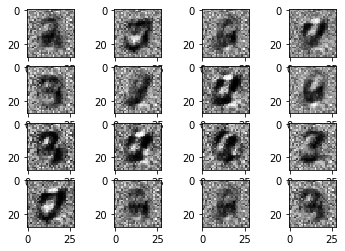

Epoch: 21
	Batch: 1	Discriminator Error: 0.170159	Generator Error: 5.092436
	Batch: 100	Discriminator Error: 0.234859	Generator Error: 4.205764
	Batch: 200	Discriminator Error: 0.128930	Generator Error: 3.929508
	Batch: 300	Discriminator Error: 0.380648	Generator Error: 4.117207
	Batch: 400	Discriminator Error: 0.227930	Generator Error: 4.270508
	Batch: 500	Discriminator Error: 0.200949	Generator Error: 3.888149
	Batch: 600	Discriminator Error: 0.090179	Generator Error: 4.367095


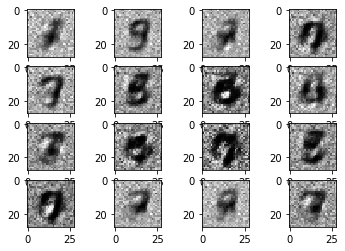

Epoch: 22
	Batch: 1	Discriminator Error: 0.201746	Generator Error: 4.393329
	Batch: 100	Discriminator Error: 0.255942	Generator Error: 3.819901
	Batch: 200	Discriminator Error: 0.266622	Generator Error: 4.301986
	Batch: 300	Discriminator Error: 0.254964	Generator Error: 4.379868
	Batch: 400	Discriminator Error: 0.148198	Generator Error: 4.251917
	Batch: 500	Discriminator Error: 0.160097	Generator Error: 4.693138
	Batch: 600	Discriminator Error: 0.107254	Generator Error: 4.758455


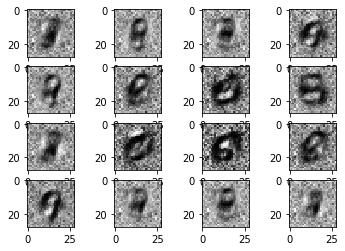

Epoch: 23
	Batch: 1	Discriminator Error: 0.149518	Generator Error: 4.926548
	Batch: 100	Discriminator Error: 0.231172	Generator Error: 4.645091
	Batch: 200	Discriminator Error: 0.238499	Generator Error: 3.986422
	Batch: 300	Discriminator Error: 0.170014	Generator Error: 4.253979
	Batch: 400	Discriminator Error: 0.093663	Generator Error: 4.605456
	Batch: 500	Discriminator Error: 0.234047	Generator Error: 4.569411
	Batch: 600	Discriminator Error: 0.258175	Generator Error: 3.913754


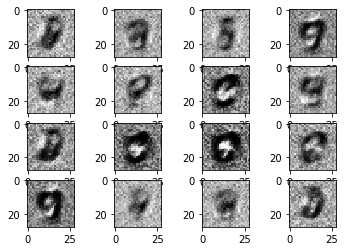

Epoch: 24
	Batch: 1	Discriminator Error: 0.184202	Generator Error: 4.094283
	Batch: 100	Discriminator Error: 0.369380	Generator Error: 3.826974
	Batch: 200	Discriminator Error: 0.221301	Generator Error: 4.028540
	Batch: 300	Discriminator Error: 0.146177	Generator Error: 3.576087
	Batch: 400	Discriminator Error: 0.590269	Generator Error: 4.621568
	Batch: 500	Discriminator Error: 0.287267	Generator Error: 4.596713
	Batch: 600	Discriminator Error: 0.351151	Generator Error: 5.689575


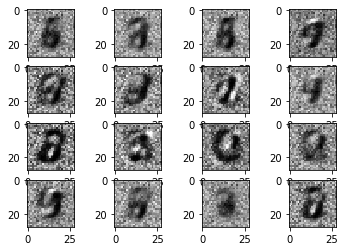

Epoch: 25
	Batch: 1	Discriminator Error: 0.170378	Generator Error: 5.538676
	Batch: 100	Discriminator Error: 0.197295	Generator Error: 4.179394
	Batch: 200	Discriminator Error: 0.241308	Generator Error: 3.674630
	Batch: 300	Discriminator Error: 0.223461	Generator Error: 4.441882
	Batch: 400	Discriminator Error: 0.169596	Generator Error: 4.387580
	Batch: 500	Discriminator Error: 0.167407	Generator Error: 4.204662
	Batch: 600	Discriminator Error: 0.225596	Generator Error: 4.329026


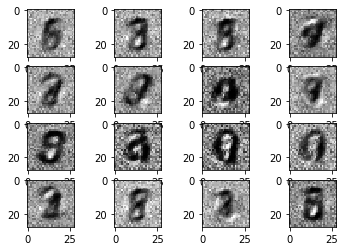

Epoch: 26
	Batch: 1	Discriminator Error: 0.285464	Generator Error: 4.178083
	Batch: 100	Discriminator Error: 0.130569	Generator Error: 4.655329
	Batch: 200	Discriminator Error: 0.228980	Generator Error: 4.258900
	Batch: 300	Discriminator Error: 0.199203	Generator Error: 3.734385
	Batch: 400	Discriminator Error: 0.255988	Generator Error: 5.127090
	Batch: 500	Discriminator Error: 0.204387	Generator Error: 4.484873
	Batch: 600	Discriminator Error: 0.265993	Generator Error: 4.098902


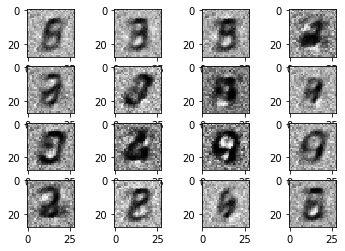

Epoch: 27
	Batch: 1	Discriminator Error: 0.257256	Generator Error: 4.126475
	Batch: 100	Discriminator Error: 0.161904	Generator Error: 3.887946
	Batch: 200	Discriminator Error: 0.170770	Generator Error: 4.125772
	Batch: 300	Discriminator Error: 0.319080	Generator Error: 4.985070
	Batch: 400	Discriminator Error: 0.265261	Generator Error: 4.371426
	Batch: 500	Discriminator Error: 0.399474	Generator Error: 3.806682
	Batch: 600	Discriminator Error: 0.398878	Generator Error: 4.728752


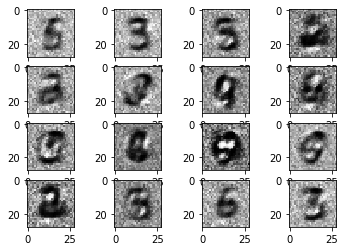

Epoch: 28
	Batch: 1	Discriminator Error: 0.166695	Generator Error: 4.352807
	Batch: 100	Discriminator Error: 0.203339	Generator Error: 4.220490
	Batch: 200	Discriminator Error: 0.294493	Generator Error: 4.806810
	Batch: 300	Discriminator Error: 0.209500	Generator Error: 3.854427
	Batch: 400	Discriminator Error: 0.246592	Generator Error: 5.137425
	Batch: 500	Discriminator Error: 0.330718	Generator Error: 4.505495
	Batch: 600	Discriminator Error: 0.206256	Generator Error: 4.306430


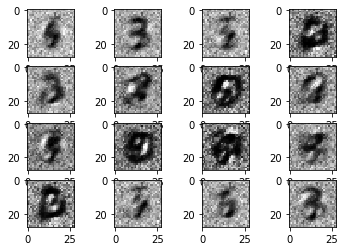

Epoch: 29
	Batch: 1	Discriminator Error: 0.248842	Generator Error: 4.352051
	Batch: 100	Discriminator Error: 0.353071	Generator Error: 3.673658
	Batch: 200	Discriminator Error: 0.167057	Generator Error: 3.957844
	Batch: 300	Discriminator Error: 0.356571	Generator Error: 4.334888
	Batch: 400	Discriminator Error: 0.325725	Generator Error: 4.221611
	Batch: 500	Discriminator Error: 0.318432	Generator Error: 3.814394
	Batch: 600	Discriminator Error: 0.296304	Generator Error: 4.084764


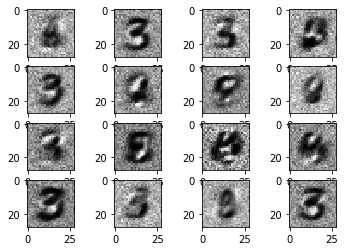

Epoch: 30
	Batch: 1	Discriminator Error: 0.264832	Generator Error: 3.946477
	Batch: 100	Discriminator Error: 0.234714	Generator Error: 4.804614
	Batch: 200	Discriminator Error: 0.156212	Generator Error: 3.481263
	Batch: 300	Discriminator Error: 0.269242	Generator Error: 3.994263
	Batch: 400	Discriminator Error: 0.181675	Generator Error: 4.547495
	Batch: 500	Discriminator Error: 0.177187	Generator Error: 5.043949
	Batch: 600	Discriminator Error: 0.160584	Generator Error: 3.897834


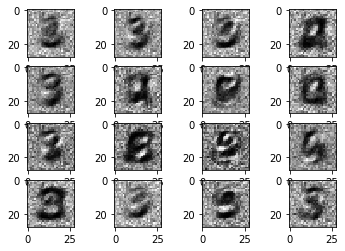

Epoch: 31
	Batch: 1	Discriminator Error: 0.243081	Generator Error: 3.475542
	Batch: 100	Discriminator Error: 0.104111	Generator Error: 4.379739
	Batch: 200	Discriminator Error: 0.233943	Generator Error: 4.061057
	Batch: 300	Discriminator Error: 0.305075	Generator Error: 4.462769
	Batch: 400	Discriminator Error: 0.294721	Generator Error: 4.306969
	Batch: 500	Discriminator Error: 0.437230	Generator Error: 4.308198
	Batch: 600	Discriminator Error: 0.213225	Generator Error: 4.488862


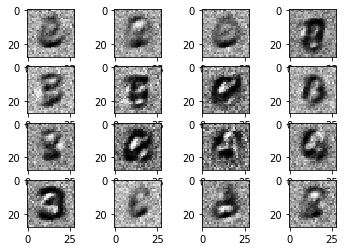

Epoch: 32
	Batch: 1	Discriminator Error: 0.355756	Generator Error: 4.635454
	Batch: 100	Discriminator Error: 0.175160	Generator Error: 4.243317
	Batch: 200	Discriminator Error: 0.287991	Generator Error: 4.202449
	Batch: 300	Discriminator Error: 0.182455	Generator Error: 3.718813
	Batch: 400	Discriminator Error: 0.194475	Generator Error: 3.971457
	Batch: 500	Discriminator Error: 0.176530	Generator Error: 4.381430
	Batch: 600	Discriminator Error: 0.170550	Generator Error: 4.400549


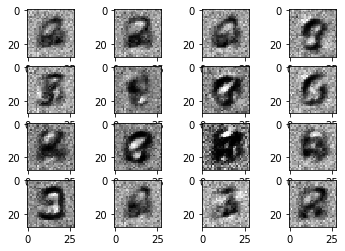

Epoch: 33
	Batch: 1	Discriminator Error: 0.148012	Generator Error: 4.489748
	Batch: 100	Discriminator Error: 0.289187	Generator Error: 4.324880
	Batch: 200	Discriminator Error: 0.232154	Generator Error: 4.061136
	Batch: 300	Discriminator Error: 0.325645	Generator Error: 4.292195
	Batch: 400	Discriminator Error: 0.172893	Generator Error: 4.732179
	Batch: 500	Discriminator Error: 0.232813	Generator Error: 3.998714
	Batch: 600	Discriminator Error: 0.257109	Generator Error: 3.511641


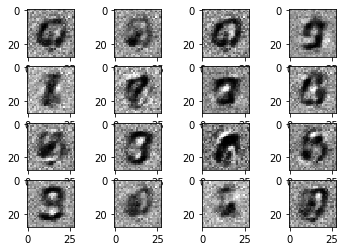

Epoch: 34
	Batch: 1	Discriminator Error: 0.228394	Generator Error: 3.748440
	Batch: 100	Discriminator Error: 0.214608	Generator Error: 4.051706
	Batch: 200	Discriminator Error: 0.267156	Generator Error: 3.847014
	Batch: 300	Discriminator Error: 0.162696	Generator Error: 4.146830
	Batch: 400	Discriminator Error: 0.414797	Generator Error: 3.227786
	Batch: 500	Discriminator Error: 0.166406	Generator Error: 4.270964
	Batch: 600	Discriminator Error: 0.279869	Generator Error: 3.756612


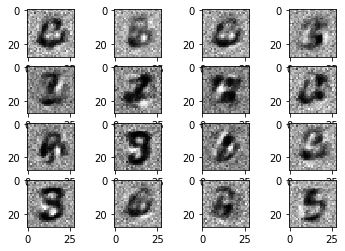

Epoch: 35
	Batch: 1	Discriminator Error: 0.233837	Generator Error: 4.066123
	Batch: 100	Discriminator Error: 0.187788	Generator Error: 3.867367
	Batch: 200	Discriminator Error: 0.181425	Generator Error: 4.538328
	Batch: 300	Discriminator Error: 0.171959	Generator Error: 4.226883
	Batch: 400	Discriminator Error: 0.307533	Generator Error: 5.045880
	Batch: 500	Discriminator Error: 0.331183	Generator Error: 3.572117
	Batch: 600	Discriminator Error: 0.308522	Generator Error: 3.700169


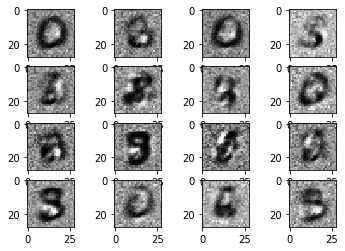

Epoch: 36
	Batch: 1	Discriminator Error: 0.302387	Generator Error: 4.081182
	Batch: 100	Discriminator Error: 0.371448	Generator Error: 4.555688
	Batch: 200	Discriminator Error: 0.293095	Generator Error: 4.594084
	Batch: 300	Discriminator Error: 0.451864	Generator Error: 4.191163
	Batch: 400	Discriminator Error: 0.294003	Generator Error: 3.328049
	Batch: 500	Discriminator Error: 0.317064	Generator Error: 3.803818
	Batch: 600	Discriminator Error: 0.355515	Generator Error: 4.213068


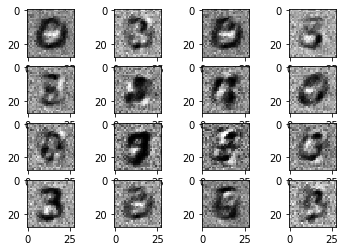

Epoch: 37
	Batch: 1	Discriminator Error: 0.276351	Generator Error: 4.244787
	Batch: 100	Discriminator Error: 0.279723	Generator Error: 3.826331
	Batch: 200	Discriminator Error: 0.268441	Generator Error: 4.058873
	Batch: 300	Discriminator Error: 0.353174	Generator Error: 4.090567
	Batch: 400	Discriminator Error: 0.446998	Generator Error: 3.984756
	Batch: 500	Discriminator Error: 0.203882	Generator Error: 4.536535
	Batch: 600	Discriminator Error: 0.235209	Generator Error: 3.925297


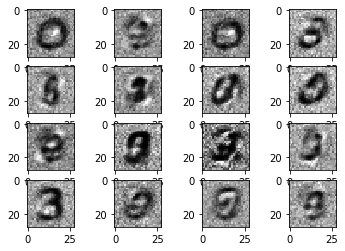

Epoch: 38
	Batch: 1	Discriminator Error: 0.199040	Generator Error: 4.161899
	Batch: 100	Discriminator Error: 0.282695	Generator Error: 3.765470
	Batch: 200	Discriminator Error: 0.272523	Generator Error: 4.171832
	Batch: 300	Discriminator Error: 0.225161	Generator Error: 4.236403
	Batch: 400	Discriminator Error: 0.145360	Generator Error: 4.067108
	Batch: 500	Discriminator Error: 0.446847	Generator Error: 4.387396
	Batch: 600	Discriminator Error: 0.274899	Generator Error: 3.430590


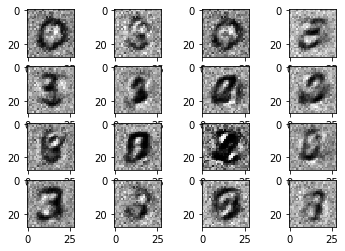

Epoch: 39
	Batch: 1	Discriminator Error: 0.316700	Generator Error: 3.774967
	Batch: 100	Discriminator Error: 0.340666	Generator Error: 4.604085
	Batch: 200	Discriminator Error: 0.231237	Generator Error: 4.136673
	Batch: 300	Discriminator Error: 0.219746	Generator Error: 4.146775
	Batch: 400	Discriminator Error: 0.281501	Generator Error: 3.873619
	Batch: 500	Discriminator Error: 0.237905	Generator Error: 4.161925
	Batch: 600	Discriminator Error: 0.140195	Generator Error: 3.886840


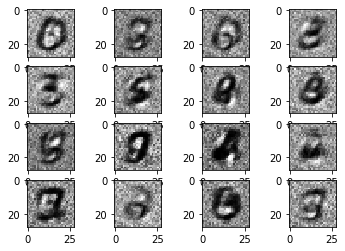

Epoch: 40
	Batch: 1	Discriminator Error: 0.264579	Generator Error: 3.663474
	Batch: 100	Discriminator Error: 0.263985	Generator Error: 4.083082
	Batch: 200	Discriminator Error: 0.335479	Generator Error: 3.400938
	Batch: 300	Discriminator Error: 0.262190	Generator Error: 3.344949
	Batch: 400	Discriminator Error: 0.184323	Generator Error: 3.748567
	Batch: 500	Discriminator Error: 0.249067	Generator Error: 3.777044
	Batch: 600	Discriminator Error: 0.265882	Generator Error: 4.822580


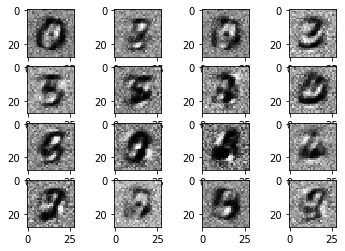

Epoch: 41
	Batch: 1	Discriminator Error: 0.232344	Generator Error: 4.637690
	Batch: 100	Discriminator Error: 0.159862	Generator Error: 3.714770
	Batch: 200	Discriminator Error: 0.480557	Generator Error: 3.982798
	Batch: 300	Discriminator Error: 0.276479	Generator Error: 3.844808
	Batch: 400	Discriminator Error: 0.346783	Generator Error: 3.352163
	Batch: 500	Discriminator Error: 0.323787	Generator Error: 3.856438
	Batch: 600	Discriminator Error: 0.196656	Generator Error: 4.538062


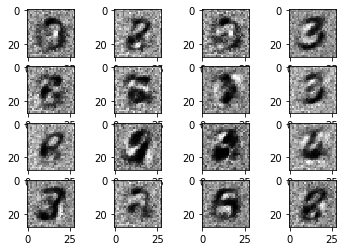

Epoch: 42
	Batch: 1	Discriminator Error: 0.269658	Generator Error: 3.883296
	Batch: 100	Discriminator Error: 0.288985	Generator Error: 4.194763
	Batch: 200	Discriminator Error: 0.314227	Generator Error: 4.351929
	Batch: 300	Discriminator Error: 0.281758	Generator Error: 4.171529
	Batch: 400	Discriminator Error: 0.190518	Generator Error: 4.107054
	Batch: 500	Discriminator Error: 0.273938	Generator Error: 3.948077
	Batch: 600	Discriminator Error: 0.194840	Generator Error: 3.937852


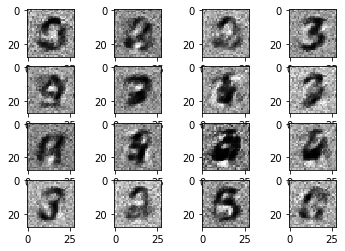

Epoch: 43
	Batch: 1	Discriminator Error: 0.170756	Generator Error: 3.896938
	Batch: 100	Discriminator Error: 0.389370	Generator Error: 4.427305
	Batch: 200	Discriminator Error: 0.308668	Generator Error: 4.066361
	Batch: 300	Discriminator Error: 0.197166	Generator Error: 4.414200
	Batch: 400	Discriminator Error: 0.247031	Generator Error: 4.070107
	Batch: 500	Discriminator Error: 0.292004	Generator Error: 3.782217
	Batch: 600	Discriminator Error: 0.219819	Generator Error: 4.404709


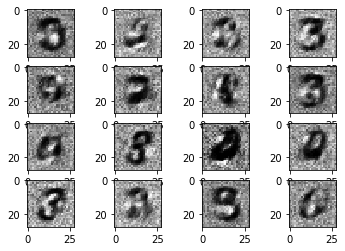

Epoch: 44
	Batch: 1	Discriminator Error: 0.235509	Generator Error: 4.645453
	Batch: 100	Discriminator Error: 0.366891	Generator Error: 4.039880
	Batch: 200	Discriminator Error: 0.206347	Generator Error: 3.741779
	Batch: 300	Discriminator Error: 0.187314	Generator Error: 4.112277
	Batch: 400	Discriminator Error: 0.246138	Generator Error: 3.787751
	Batch: 500	Discriminator Error: 0.423401	Generator Error: 3.525495
	Batch: 600	Discriminator Error: 0.194240	Generator Error: 4.327648


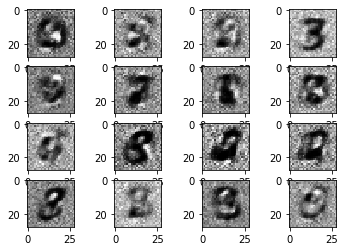

Epoch: 45
	Batch: 1	Discriminator Error: 0.172311	Generator Error: 4.091938
	Batch: 100	Discriminator Error: 0.254414	Generator Error: 4.140429
	Batch: 200	Discriminator Error: 0.248003	Generator Error: 3.953273
	Batch: 300	Discriminator Error: 0.340815	Generator Error: 3.624358
	Batch: 400	Discriminator Error: 0.341427	Generator Error: 4.196507
	Batch: 500	Discriminator Error: 0.362338	Generator Error: 3.299040
	Batch: 600	Discriminator Error: 0.261531	Generator Error: 3.320688


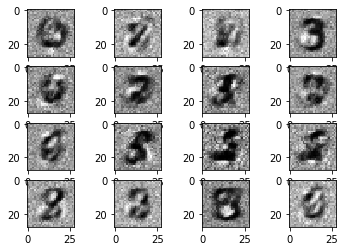

Epoch: 46
	Batch: 1	Discriminator Error: 0.333553	Generator Error: 3.560170
	Batch: 100	Discriminator Error: 0.437551	Generator Error: 3.717988
	Batch: 200	Discriminator Error: 0.455122	Generator Error: 3.445683
	Batch: 300	Discriminator Error: 0.217979	Generator Error: 3.673550
	Batch: 400	Discriminator Error: 0.252174	Generator Error: 3.951744
	Batch: 500	Discriminator Error: 0.248152	Generator Error: 4.040813
	Batch: 600	Discriminator Error: 0.336959	Generator Error: 3.347302


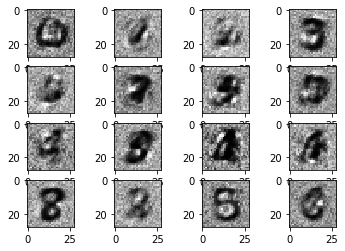

Epoch: 47
	Batch: 1	Discriminator Error: 0.332664	Generator Error: 3.679745
	Batch: 100	Discriminator Error: 0.255155	Generator Error: 3.850572
	Batch: 200	Discriminator Error: 0.462164	Generator Error: 4.510741
	Batch: 300	Discriminator Error: 0.363944	Generator Error: 3.605738
	Batch: 400	Discriminator Error: 0.407795	Generator Error: 4.255354
	Batch: 500	Discriminator Error: 0.306952	Generator Error: 4.161849
	Batch: 600	Discriminator Error: 0.325502	Generator Error: 4.019505


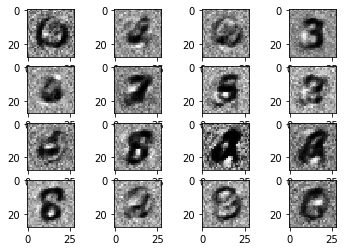

Epoch: 48
	Batch: 1	Discriminator Error: 0.347446	Generator Error: 3.959605
	Batch: 100	Discriminator Error: 0.250163	Generator Error: 3.904355
	Batch: 200	Discriminator Error: 0.410558	Generator Error: 3.660933
	Batch: 300	Discriminator Error: 0.336053	Generator Error: 3.234692
	Batch: 400	Discriminator Error: 0.266053	Generator Error: 4.562759
	Batch: 500	Discriminator Error: 0.375587	Generator Error: 4.141711
	Batch: 600	Discriminator Error: 0.266507	Generator Error: 3.974082


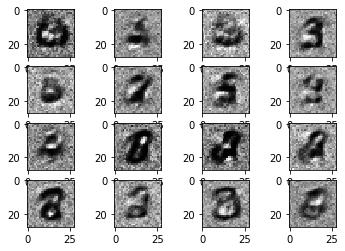

Epoch: 49
	Batch: 1	Discriminator Error: 0.311538	Generator Error: 3.844839
	Batch: 100	Discriminator Error: 0.197216	Generator Error: 3.834637
	Batch: 200	Discriminator Error: 0.237324	Generator Error: 4.449568
	Batch: 300	Discriminator Error: 0.310316	Generator Error: 4.386534
	Batch: 400	Discriminator Error: 0.223805	Generator Error: 3.853882
	Batch: 500	Discriminator Error: 0.365869	Generator Error: 3.769985
	Batch: 600	Discriminator Error: 0.215572	Generator Error: 3.889850


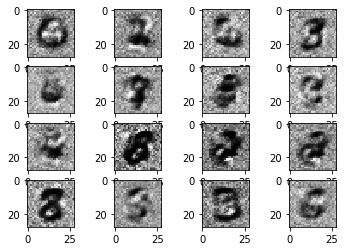

Epoch: 50
	Batch: 1	Discriminator Error: 0.321822	Generator Error: 3.700128
	Batch: 100	Discriminator Error: 0.242987	Generator Error: 4.051576
	Batch: 200	Discriminator Error: 0.275237	Generator Error: 3.566796
	Batch: 300	Discriminator Error: 0.224713	Generator Error: 3.691341
	Batch: 400	Discriminator Error: 0.175002	Generator Error: 3.738860
	Batch: 500	Discriminator Error: 0.329769	Generator Error: 4.305638
	Batch: 600	Discriminator Error: 0.232380	Generator Error: 4.156929


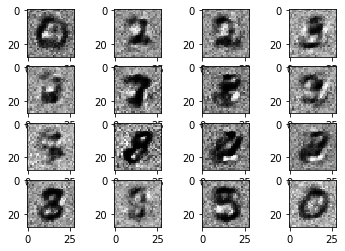

Epoch: 51
	Batch: 1	Discriminator Error: 0.272035	Generator Error: 4.546550
	Batch: 100	Discriminator Error: 0.348055	Generator Error: 4.294119
	Batch: 200	Discriminator Error: 0.218953	Generator Error: 3.722039
	Batch: 300	Discriminator Error: 0.297565	Generator Error: 3.849030
	Batch: 400	Discriminator Error: 0.199965	Generator Error: 3.809386
	Batch: 500	Discriminator Error: 0.123590	Generator Error: 4.129288
	Batch: 600	Discriminator Error: 0.465210	Generator Error: 3.575564


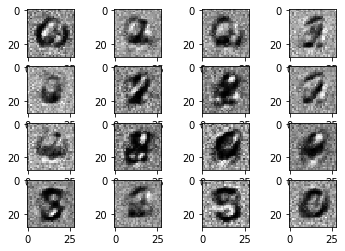

Epoch: 52
	Batch: 1	Discriminator Error: 0.285496	Generator Error: 3.064141
	Batch: 100	Discriminator Error: 0.339294	Generator Error: 4.177951
	Batch: 200	Discriminator Error: 0.260520	Generator Error: 3.691351
	Batch: 300	Discriminator Error: 0.446594	Generator Error: 3.934323
	Batch: 400	Discriminator Error: 0.349794	Generator Error: 2.933818
	Batch: 500	Discriminator Error: 0.351625	Generator Error: 3.677101
	Batch: 600	Discriminator Error: 0.354662	Generator Error: 3.243282


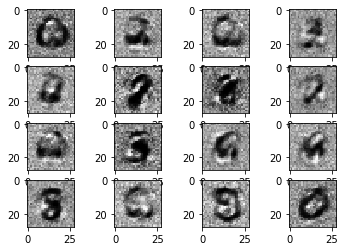

Epoch: 53
	Batch: 1	Discriminator Error: 0.416030	Generator Error: 3.382041
	Batch: 100	Discriminator Error: 0.282087	Generator Error: 3.339530
	Batch: 200	Discriminator Error: 0.373925	Generator Error: 4.343692
	Batch: 300	Discriminator Error: 0.288844	Generator Error: 4.029951
	Batch: 400	Discriminator Error: 0.453803	Generator Error: 4.724475
	Batch: 500	Discriminator Error: 0.270067	Generator Error: 3.715538
	Batch: 600	Discriminator Error: 0.230547	Generator Error: 3.948480


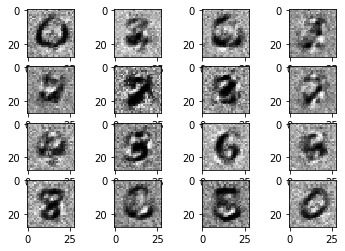

Epoch: 54
	Batch: 1	Discriminator Error: 0.373338	Generator Error: 3.522621
	Batch: 100	Discriminator Error: 0.280354	Generator Error: 3.746487
	Batch: 200	Discriminator Error: 0.495154	Generator Error: 3.817172
	Batch: 300	Discriminator Error: 0.226841	Generator Error: 4.325378
	Batch: 400	Discriminator Error: 0.205846	Generator Error: 3.986962
	Batch: 500	Discriminator Error: 0.236711	Generator Error: 3.450284
	Batch: 600	Discriminator Error: 0.147126	Generator Error: 4.208749


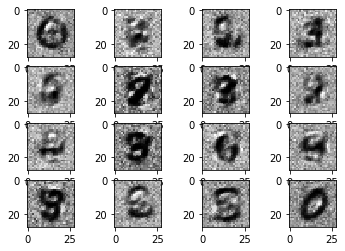

Epoch: 55
	Batch: 1	Discriminator Error: 0.191706	Generator Error: 4.493300
	Batch: 100	Discriminator Error: 0.283065	Generator Error: 3.552006
	Batch: 200	Discriminator Error: 0.276339	Generator Error: 4.267846
	Batch: 300	Discriminator Error: 0.350035	Generator Error: 3.737745
	Batch: 400	Discriminator Error: 0.246224	Generator Error: 3.958955
	Batch: 500	Discriminator Error: 0.240756	Generator Error: 3.374004
	Batch: 600	Discriminator Error: 0.206409	Generator Error: 3.652467


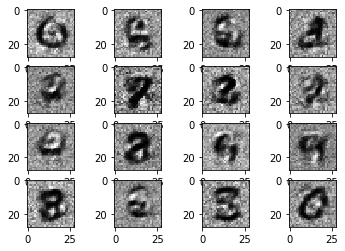

Epoch: 56
	Batch: 1	Discriminator Error: 0.187357	Generator Error: 3.787278
	Batch: 100	Discriminator Error: 0.165805	Generator Error: 3.628541
	Batch: 200	Discriminator Error: 0.403045	Generator Error: 3.505224
	Batch: 300	Discriminator Error: 0.264067	Generator Error: 3.524002
	Batch: 400	Discriminator Error: 0.165689	Generator Error: 3.820130
	Batch: 500	Discriminator Error: 0.411122	Generator Error: 3.694401
	Batch: 600	Discriminator Error: 0.212012	Generator Error: 3.674850


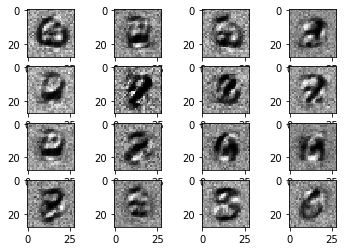

Epoch: 57
	Batch: 1	Discriminator Error: 0.229480	Generator Error: 3.865524
	Batch: 100	Discriminator Error: 0.384643	Generator Error: 3.943626
	Batch: 200	Discriminator Error: 0.257192	Generator Error: 4.239059
	Batch: 300	Discriminator Error: 0.268603	Generator Error: 3.008733
	Batch: 400	Discriminator Error: 0.323915	Generator Error: 4.429341
	Batch: 500	Discriminator Error: 0.156098	Generator Error: 4.329754
	Batch: 600	Discriminator Error: 0.269219	Generator Error: 4.086234


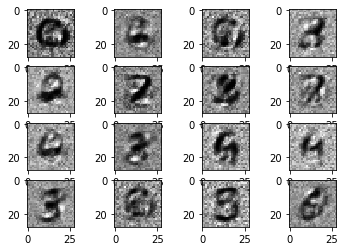

Epoch: 58
	Batch: 1	Discriminator Error: 0.331859	Generator Error: 3.990673
	Batch: 100	Discriminator Error: 0.291045	Generator Error: 3.931768
	Batch: 200	Discriminator Error: 0.304752	Generator Error: 3.718004
	Batch: 300	Discriminator Error: 0.316141	Generator Error: 3.198912
	Batch: 400	Discriminator Error: 0.414095	Generator Error: 3.191390
	Batch: 500	Discriminator Error: 0.220963	Generator Error: 4.154184
	Batch: 600	Discriminator Error: 0.342486	Generator Error: 4.016011


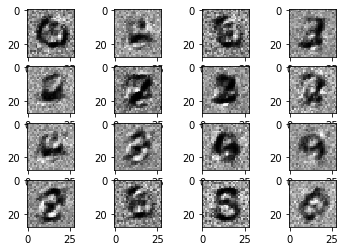

Epoch: 59
	Batch: 1	Discriminator Error: 0.428488	Generator Error: 4.233458
	Batch: 100	Discriminator Error: 0.241792	Generator Error: 3.887020
	Batch: 200	Discriminator Error: 0.244628	Generator Error: 3.677687
	Batch: 300	Discriminator Error: 0.313791	Generator Error: 3.766771
	Batch: 400	Discriminator Error: 0.243680	Generator Error: 4.070827
	Batch: 500	Discriminator Error: 0.151652	Generator Error: 3.605259
	Batch: 600	Discriminator Error: 0.203681	Generator Error: 3.683719


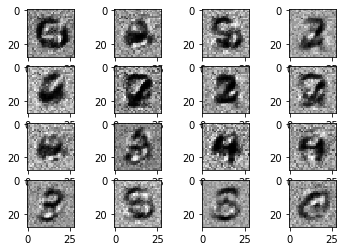

Epoch: 60
	Batch: 1	Discriminator Error: 0.228130	Generator Error: 3.934553
	Batch: 100	Discriminator Error: 0.268701	Generator Error: 3.940153
	Batch: 200	Discriminator Error: 0.377172	Generator Error: 3.292471
	Batch: 300	Discriminator Error: 0.218823	Generator Error: 3.682889
	Batch: 400	Discriminator Error: 0.235875	Generator Error: 4.075012
	Batch: 500	Discriminator Error: 0.309904	Generator Error: 3.957474
	Batch: 600	Discriminator Error: 0.274385	Generator Error: 3.942031


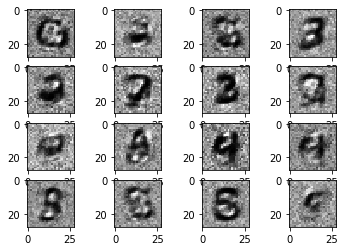

Epoch: 61
	Batch: 1	Discriminator Error: 0.273096	Generator Error: 3.905076
	Batch: 100	Discriminator Error: 0.207552	Generator Error: 3.832560
	Batch: 200	Discriminator Error: 0.429367	Generator Error: 3.419318
	Batch: 300	Discriminator Error: 0.270500	Generator Error: 3.385778
	Batch: 400	Discriminator Error: 0.302993	Generator Error: 3.873535
	Batch: 500	Discriminator Error: 0.392657	Generator Error: 4.028405
	Batch: 600	Discriminator Error: 0.291202	Generator Error: 3.761001


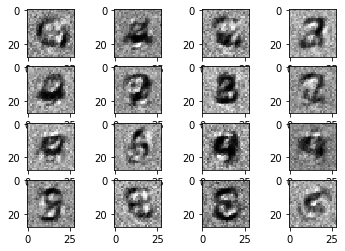

Epoch: 62
	Batch: 1	Discriminator Error: 0.302238	Generator Error: 3.615959
	Batch: 100	Discriminator Error: 0.264266	Generator Error: 3.436495
	Batch: 200	Discriminator Error: 0.255701	Generator Error: 3.458545
	Batch: 300	Discriminator Error: 0.265045	Generator Error: 4.660955
	Batch: 400	Discriminator Error: 0.310421	Generator Error: 4.223336
	Batch: 500	Discriminator Error: 0.309944	Generator Error: 3.228532
	Batch: 600	Discriminator Error: 0.280165	Generator Error: 3.379112


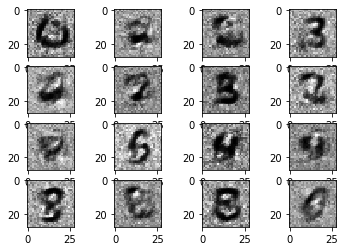

Epoch: 63
	Batch: 1	Discriminator Error: 0.411931	Generator Error: 3.204997
	Batch: 100	Discriminator Error: 0.280205	Generator Error: 3.890664
	Batch: 200	Discriminator Error: 0.166072	Generator Error: 4.128651
	Batch: 300	Discriminator Error: 0.424756	Generator Error: 3.440495
	Batch: 400	Discriminator Error: 0.330073	Generator Error: 3.559276
	Batch: 500	Discriminator Error: 0.208807	Generator Error: 3.613925
	Batch: 600	Discriminator Error: 0.246421	Generator Error: 3.470124


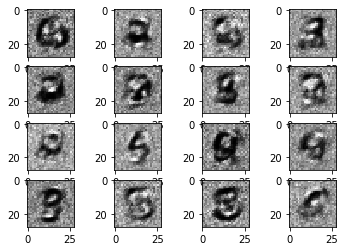

Epoch: 64
	Batch: 1	Discriminator Error: 0.338873	Generator Error: 3.732580
	Batch: 100	Discriminator Error: 0.349835	Generator Error: 3.640742
	Batch: 200	Discriminator Error: 0.282125	Generator Error: 4.125173
	Batch: 300	Discriminator Error: 0.226396	Generator Error: 3.396910
	Batch: 400	Discriminator Error: 0.262067	Generator Error: 4.081019
	Batch: 500	Discriminator Error: 0.270223	Generator Error: 3.245402
	Batch: 600	Discriminator Error: 0.315777	Generator Error: 3.268260


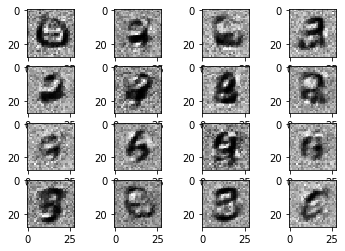

Epoch: 65
	Batch: 1	Discriminator Error: 0.290221	Generator Error: 3.568353
	Batch: 100	Discriminator Error: 0.282439	Generator Error: 3.360685
	Batch: 200	Discriminator Error: 0.284373	Generator Error: 3.766536
	Batch: 300	Discriminator Error: 0.387549	Generator Error: 4.025560
	Batch: 400	Discriminator Error: 0.252493	Generator Error: 4.031947
	Batch: 500	Discriminator Error: 0.386404	Generator Error: 3.774825
	Batch: 600	Discriminator Error: 0.344577	Generator Error: 3.695482


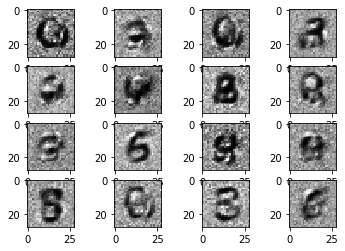

Epoch: 66
	Batch: 1	Discriminator Error: 0.366129	Generator Error: 3.455401
	Batch: 100	Discriminator Error: 0.389475	Generator Error: 4.094964
	Batch: 200	Discriminator Error: 0.234222	Generator Error: 4.506710
	Batch: 300	Discriminator Error: 0.539814	Generator Error: 3.580332
	Batch: 400	Discriminator Error: 0.514497	Generator Error: 3.398146
	Batch: 500	Discriminator Error: 0.298326	Generator Error: 3.783609
	Batch: 600	Discriminator Error: 0.286475	Generator Error: 3.844050


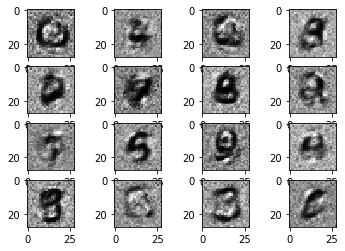

Epoch: 67
	Batch: 1	Discriminator Error: 0.244734	Generator Error: 3.569248
	Batch: 100	Discriminator Error: 0.419362	Generator Error: 3.660447
	Batch: 200	Discriminator Error: 0.188054	Generator Error: 3.867873
	Batch: 300	Discriminator Error: 0.334749	Generator Error: 3.404942
	Batch: 400	Discriminator Error: 0.316653	Generator Error: 3.502310
	Batch: 500	Discriminator Error: 0.295801	Generator Error: 4.179452
	Batch: 600	Discriminator Error: 0.314005	Generator Error: 3.735768


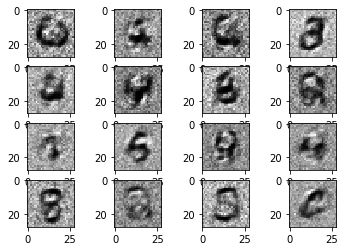

Epoch: 68
	Batch: 1	Discriminator Error: 0.340012	Generator Error: 3.412647
	Batch: 100	Discriminator Error: 0.341895	Generator Error: 3.093184
	Batch: 200	Discriminator Error: 0.314768	Generator Error: 3.785165
	Batch: 300	Discriminator Error: 0.441597	Generator Error: 3.932906
	Batch: 400	Discriminator Error: 0.293497	Generator Error: 3.869776
	Batch: 500	Discriminator Error: 0.237466	Generator Error: 3.917573
	Batch: 600	Discriminator Error: 0.199547	Generator Error: 4.193742


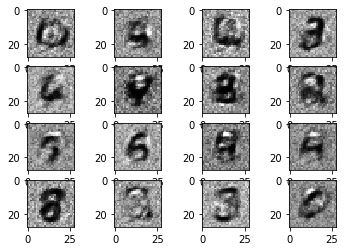

Epoch: 69
	Batch: 1	Discriminator Error: 0.242814	Generator Error: 4.129180
	Batch: 100	Discriminator Error: 0.247654	Generator Error: 3.653918
	Batch: 200	Discriminator Error: 0.273191	Generator Error: 4.032660
	Batch: 300	Discriminator Error: 0.192487	Generator Error: 4.094780
	Batch: 400	Discriminator Error: 0.361017	Generator Error: 2.944195
	Batch: 500	Discriminator Error: 0.307041	Generator Error: 3.390814
	Batch: 600	Discriminator Error: 0.223221	Generator Error: 4.544409


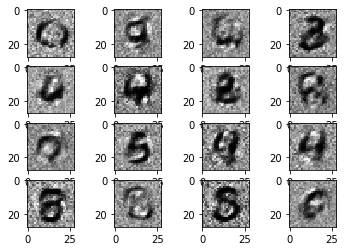

Epoch: 70
	Batch: 1	Discriminator Error: 0.332890	Generator Error: 4.046781
	Batch: 100	Discriminator Error: 0.313974	Generator Error: 3.785150
	Batch: 200	Discriminator Error: 0.278543	Generator Error: 3.453607
	Batch: 300	Discriminator Error: 0.313617	Generator Error: 3.593617
	Batch: 400	Discriminator Error: 0.201464	Generator Error: 3.994598
	Batch: 500	Discriminator Error: 0.289878	Generator Error: 4.096304
	Batch: 600	Discriminator Error: 0.218647	Generator Error: 4.324945


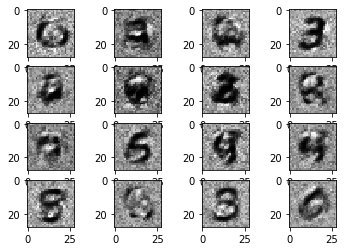

Epoch: 71
	Batch: 1	Discriminator Error: 0.299601	Generator Error: 4.167800
	Batch: 100	Discriminator Error: 0.310947	Generator Error: 3.580995
	Batch: 200	Discriminator Error: 0.547885	Generator Error: 3.328497
	Batch: 300	Discriminator Error: 0.434005	Generator Error: 3.706434
	Batch: 400	Discriminator Error: 0.237122	Generator Error: 3.679602
	Batch: 500	Discriminator Error: 0.228142	Generator Error: 3.621536
	Batch: 600	Discriminator Error: 0.575829	Generator Error: 3.176429


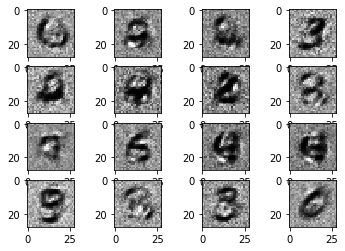

Epoch: 72
	Batch: 1	Discriminator Error: 0.191534	Generator Error: 3.035359
	Batch: 100	Discriminator Error: 0.297907	Generator Error: 4.498104
	Batch: 200	Discriminator Error: 0.211383	Generator Error: 3.755879
	Batch: 300	Discriminator Error: 0.355059	Generator Error: 3.293363
	Batch: 400	Discriminator Error: 0.351803	Generator Error: 3.534768
	Batch: 500	Discriminator Error: 0.427086	Generator Error: 3.405849
	Batch: 600	Discriminator Error: 0.318507	Generator Error: 3.576984


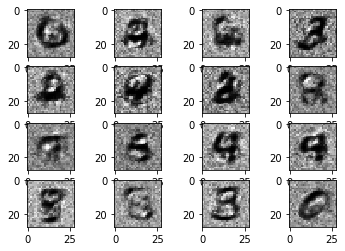

Epoch: 73
	Batch: 1	Discriminator Error: 0.304391	Generator Error: 3.174844
	Batch: 100	Discriminator Error: 0.328190	Generator Error: 3.749754
	Batch: 200	Discriminator Error: 0.276125	Generator Error: 3.165815
	Batch: 300	Discriminator Error: 0.357972	Generator Error: 3.834917
	Batch: 400	Discriminator Error: 0.314719	Generator Error: 3.777573
	Batch: 500	Discriminator Error: 0.388292	Generator Error: 3.804382
	Batch: 600	Discriminator Error: 0.401495	Generator Error: 3.426833


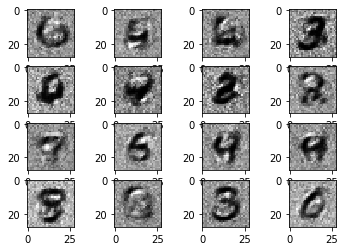

Epoch: 74
	Batch: 1	Discriminator Error: 0.415874	Generator Error: 3.455471
	Batch: 100	Discriminator Error: 0.269824	Generator Error: 3.494679
	Batch: 200	Discriminator Error: 0.264719	Generator Error: 3.578679
	Batch: 300	Discriminator Error: 0.396230	Generator Error: 3.674726
	Batch: 400	Discriminator Error: 0.218897	Generator Error: 3.704008
	Batch: 500	Discriminator Error: 0.197660	Generator Error: 4.062947
	Batch: 600	Discriminator Error: 0.227782	Generator Error: 3.456925


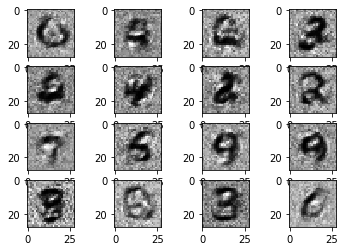

Epoch: 75
	Batch: 1	Discriminator Error: 0.406233	Generator Error: 3.429523
	Batch: 100	Discriminator Error: 0.386576	Generator Error: 3.207698
	Batch: 200	Discriminator Error: 0.222048	Generator Error: 3.606237
	Batch: 300	Discriminator Error: 0.257609	Generator Error: 3.214875
	Batch: 400	Discriminator Error: 0.372477	Generator Error: 4.029093
	Batch: 500	Discriminator Error: 0.340896	Generator Error: 4.097712
	Batch: 600	Discriminator Error: 0.256054	Generator Error: 3.167732


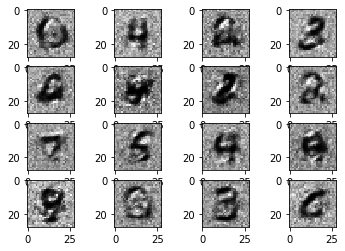

Epoch: 76
	Batch: 1	Discriminator Error: 0.322607	Generator Error: 3.072975
	Batch: 100	Discriminator Error: 0.438729	Generator Error: 3.484761
	Batch: 200	Discriminator Error: 0.289048	Generator Error: 3.708595
	Batch: 300	Discriminator Error: 0.333317	Generator Error: 3.986073
	Batch: 400	Discriminator Error: 0.282224	Generator Error: 3.524183
	Batch: 500	Discriminator Error: 0.274362	Generator Error: 3.360423
	Batch: 600	Discriminator Error: 0.346392	Generator Error: 4.020593


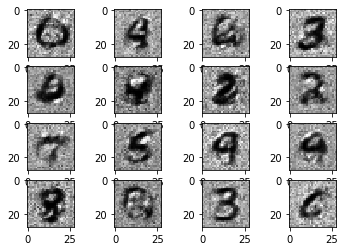

Epoch: 77
	Batch: 1	Discriminator Error: 0.387990	Generator Error: 3.777462
	Batch: 100	Discriminator Error: 0.246164	Generator Error: 3.551807
	Batch: 200	Discriminator Error: 0.421590	Generator Error: 3.862565
	Batch: 300	Discriminator Error: 0.478181	Generator Error: 3.064309
	Batch: 400	Discriminator Error: 0.312552	Generator Error: 3.925077
	Batch: 500	Discriminator Error: 0.174423	Generator Error: 4.135127
	Batch: 600	Discriminator Error: 0.290067	Generator Error: 3.625375


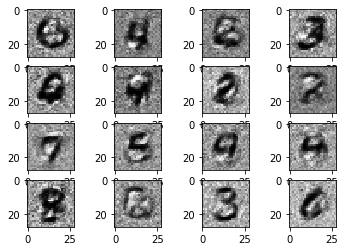

Epoch: 78
	Batch: 1	Discriminator Error: 0.212075	Generator Error: 3.653487
	Batch: 100	Discriminator Error: 0.232989	Generator Error: 3.774096
	Batch: 200	Discriminator Error: 0.254256	Generator Error: 4.194828
	Batch: 300	Discriminator Error: 0.263985	Generator Error: 4.006653
	Batch: 400	Discriminator Error: 0.243264	Generator Error: 3.662344
	Batch: 500	Discriminator Error: 0.385724	Generator Error: 3.792746
	Batch: 600	Discriminator Error: 0.304206	Generator Error: 4.090674


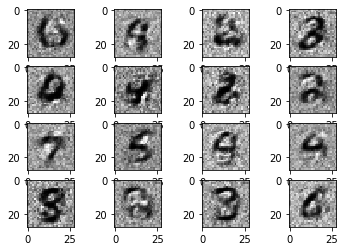

Epoch: 79
	Batch: 1	Discriminator Error: 0.387768	Generator Error: 4.149501
	Batch: 100	Discriminator Error: 0.309544	Generator Error: 4.387661
	Batch: 200	Discriminator Error: 0.386449	Generator Error: 4.294308
	Batch: 300	Discriminator Error: 0.391723	Generator Error: 4.298458
	Batch: 400	Discriminator Error: 0.498098	Generator Error: 4.197518
	Batch: 500	Discriminator Error: 0.375826	Generator Error: 3.912193
	Batch: 600	Discriminator Error: 0.445149	Generator Error: 3.588503


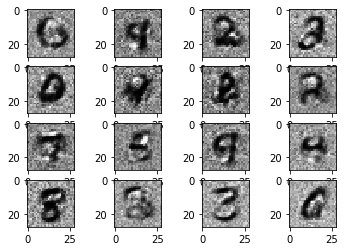

Epoch: 80
	Batch: 1	Discriminator Error: 0.272316	Generator Error: 3.652023
	Batch: 100	Discriminator Error: 0.255381	Generator Error: 4.487592
	Batch: 200	Discriminator Error: 0.403438	Generator Error: 3.075419
	Batch: 300	Discriminator Error: 0.199252	Generator Error: 3.854966
	Batch: 400	Discriminator Error: 0.408442	Generator Error: 4.133911
	Batch: 500	Discriminator Error: 0.180343	Generator Error: 4.351971
	Batch: 600	Discriminator Error: 0.280666	Generator Error: 3.898361


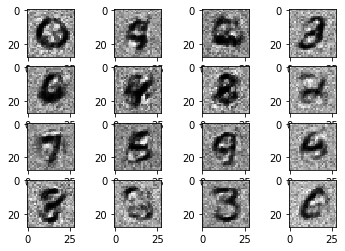

Epoch: 81
	Batch: 1	Discriminator Error: 0.403075	Generator Error: 3.530771
	Batch: 100	Discriminator Error: 0.296400	Generator Error: 3.849177
	Batch: 200	Discriminator Error: 0.262499	Generator Error: 3.480081
	Batch: 300	Discriminator Error: 0.327631	Generator Error: 4.292812
	Batch: 400	Discriminator Error: 0.215167	Generator Error: 3.945653
	Batch: 500	Discriminator Error: 0.249461	Generator Error: 3.713060
	Batch: 600	Discriminator Error: 0.284150	Generator Error: 3.765761


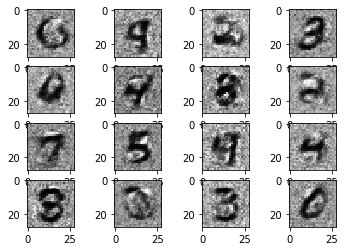

Epoch: 82
	Batch: 1	Discriminator Error: 0.260566	Generator Error: 3.795288
	Batch: 100	Discriminator Error: 0.200053	Generator Error: 4.192961
	Batch: 200	Discriminator Error: 0.237907	Generator Error: 3.811290
	Batch: 300	Discriminator Error: 0.233795	Generator Error: 3.597957
	Batch: 400	Discriminator Error: 0.288917	Generator Error: 3.891346
	Batch: 500	Discriminator Error: 0.368210	Generator Error: 4.479788
	Batch: 600	Discriminator Error: 0.259341	Generator Error: 3.645641


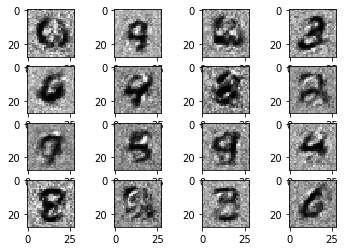

Epoch: 83
	Batch: 1	Discriminator Error: 0.228115	Generator Error: 3.492250
	Batch: 100	Discriminator Error: 0.226449	Generator Error: 4.083257
	Batch: 200	Discriminator Error: 0.179244	Generator Error: 3.910594
	Batch: 300	Discriminator Error: 0.405521	Generator Error: 4.071756
	Batch: 400	Discriminator Error: 0.396781	Generator Error: 3.631776
	Batch: 500	Discriminator Error: 0.310216	Generator Error: 3.763860
	Batch: 600	Discriminator Error: 0.275735	Generator Error: 3.814171


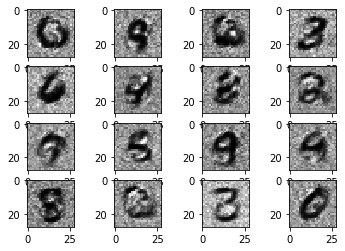

Epoch: 84
	Batch: 1	Discriminator Error: 0.244899	Generator Error: 3.803941
	Batch: 100	Discriminator Error: 0.259105	Generator Error: 3.048264
	Batch: 200	Discriminator Error: 0.240636	Generator Error: 3.959545
	Batch: 300	Discriminator Error: 0.470009	Generator Error: 3.900580
	Batch: 400	Discriminator Error: 0.291985	Generator Error: 3.986237
	Batch: 500	Discriminator Error: 0.275129	Generator Error: 4.021401
	Batch: 600	Discriminator Error: 0.280048	Generator Error: 3.464228


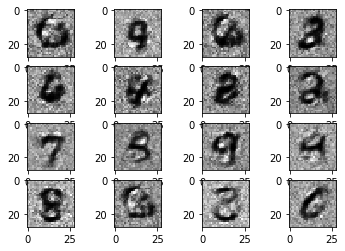

Epoch: 85
	Batch: 1	Discriminator Error: 0.310463	Generator Error: 3.337738
	Batch: 100	Discriminator Error: 0.294813	Generator Error: 3.382944
	Batch: 200	Discriminator Error: 0.310974	Generator Error: 3.777873
	Batch: 300	Discriminator Error: 0.377912	Generator Error: 3.375575
	Batch: 400	Discriminator Error: 0.283828	Generator Error: 3.051920
	Batch: 500	Discriminator Error: 0.246961	Generator Error: 3.141408
	Batch: 600	Discriminator Error: 0.232886	Generator Error: 3.728745


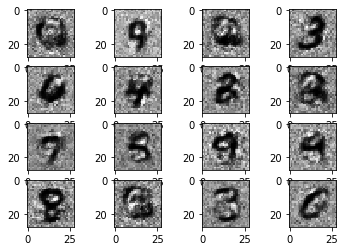

Epoch: 86
	Batch: 1	Discriminator Error: 0.264276	Generator Error: 3.943333
	Batch: 100	Discriminator Error: 0.389121	Generator Error: 3.444931
	Batch: 200	Discriminator Error: 0.475525	Generator Error: 3.231657
	Batch: 300	Discriminator Error: 0.307251	Generator Error: 4.163095
	Batch: 400	Discriminator Error: 0.244557	Generator Error: 4.364100
	Batch: 500	Discriminator Error: 0.309618	Generator Error: 3.362941
	Batch: 600	Discriminator Error: 0.303174	Generator Error: 3.532205


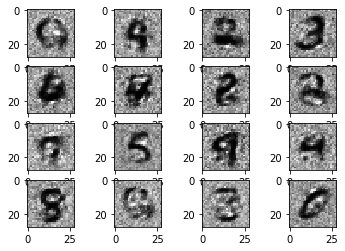

Epoch: 87
	Batch: 1	Discriminator Error: 0.380926	Generator Error: 3.590777
	Batch: 100	Discriminator Error: 0.238070	Generator Error: 3.853096
	Batch: 200	Discriminator Error: 0.230567	Generator Error: 3.660536
	Batch: 300	Discriminator Error: 0.419140	Generator Error: 4.190585
	Batch: 400	Discriminator Error: 0.205982	Generator Error: 4.170123
	Batch: 500	Discriminator Error: 0.270857	Generator Error: 3.667555
	Batch: 600	Discriminator Error: 0.338176	Generator Error: 4.006778


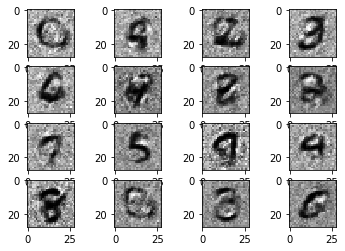

Epoch: 88
	Batch: 1	Discriminator Error: 0.262574	Generator Error: 3.930853
	Batch: 100	Discriminator Error: 0.368068	Generator Error: 3.360941
	Batch: 200	Discriminator Error: 0.196464	Generator Error: 4.423093
	Batch: 300	Discriminator Error: 0.237923	Generator Error: 4.280459
	Batch: 400	Discriminator Error: 0.233725	Generator Error: 4.183119
	Batch: 500	Discriminator Error: 0.343454	Generator Error: 3.402880
	Batch: 600	Discriminator Error: 0.202408	Generator Error: 4.217143


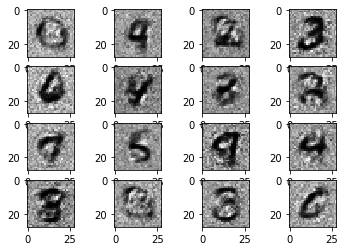

Epoch: 89
	Batch: 1	Discriminator Error: 0.318464	Generator Error: 3.873360
	Batch: 100	Discriminator Error: 0.266717	Generator Error: 3.870629
	Batch: 200	Discriminator Error: 0.245388	Generator Error: 3.847380
	Batch: 300	Discriminator Error: 0.338413	Generator Error: 4.223053
	Batch: 400	Discriminator Error: 0.369073	Generator Error: 3.994916
	Batch: 500	Discriminator Error: 0.221540	Generator Error: 3.664685
	Batch: 600	Discriminator Error: 0.275757	Generator Error: 3.479922


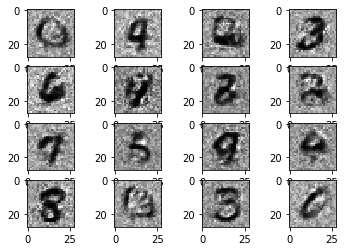

Epoch: 90
	Batch: 1	Discriminator Error: 0.380539	Generator Error: 3.267561
	Batch: 100	Discriminator Error: 0.221539	Generator Error: 3.456753
	Batch: 200	Discriminator Error: 0.225395	Generator Error: 4.030303
	Batch: 300	Discriminator Error: 0.295959	Generator Error: 3.999076
	Batch: 400	Discriminator Error: 0.342132	Generator Error: 4.227356
	Batch: 500	Discriminator Error: 0.339513	Generator Error: 3.564865
	Batch: 600	Discriminator Error: 0.395412	Generator Error: 3.603686


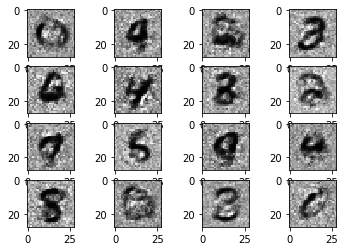

Epoch: 91
	Batch: 1	Discriminator Error: 0.209198	Generator Error: 3.639939
	Batch: 100	Discriminator Error: 0.299763	Generator Error: 3.717580
	Batch: 200	Discriminator Error: 0.238899	Generator Error: 4.017249
	Batch: 300	Discriminator Error: 0.351570	Generator Error: 3.737682
	Batch: 400	Discriminator Error: 0.208532	Generator Error: 3.383189
	Batch: 500	Discriminator Error: 0.343955	Generator Error: 3.623547
	Batch: 600	Discriminator Error: 0.309496	Generator Error: 3.728005


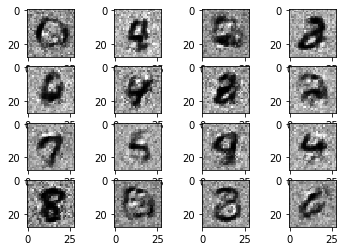

Epoch: 92
	Batch: 1	Discriminator Error: 0.281763	Generator Error: 4.033090
	Batch: 100	Discriminator Error: 0.243275	Generator Error: 3.676798
	Batch: 200	Discriminator Error: 0.307220	Generator Error: 3.914690
	Batch: 300	Discriminator Error: 0.307626	Generator Error: 4.211883
	Batch: 400	Discriminator Error: 0.401568	Generator Error: 3.655882
	Batch: 500	Discriminator Error: 0.392877	Generator Error: 3.342744
	Batch: 600	Discriminator Error: 0.400356	Generator Error: 4.025649


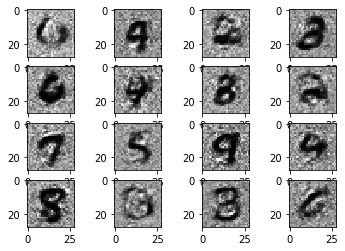

Epoch: 93
	Batch: 1	Discriminator Error: 0.226728	Generator Error: 4.045568
	Batch: 100	Discriminator Error: 0.268384	Generator Error: 3.604805
	Batch: 200	Discriminator Error: 0.391749	Generator Error: 4.346133
	Batch: 300	Discriminator Error: 0.272125	Generator Error: 3.781282
	Batch: 400	Discriminator Error: 0.313160	Generator Error: 3.651932
	Batch: 500	Discriminator Error: 0.273472	Generator Error: 3.817892
	Batch: 600	Discriminator Error: 0.325606	Generator Error: 3.782562


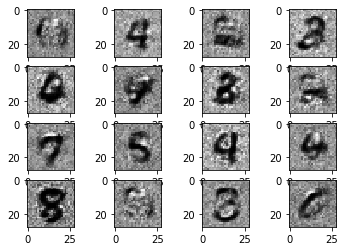

Epoch: 94
	Batch: 1	Discriminator Error: 0.245669	Generator Error: 4.007138
	Batch: 100	Discriminator Error: 0.340012	Generator Error: 3.696918
	Batch: 200	Discriminator Error: 0.372822	Generator Error: 3.919219
	Batch: 300	Discriminator Error: 0.259365	Generator Error: 3.307024
	Batch: 400	Discriminator Error: 0.257025	Generator Error: 2.945178
	Batch: 500	Discriminator Error: 0.258616	Generator Error: 3.597117
	Batch: 600	Discriminator Error: 0.303807	Generator Error: 4.061739


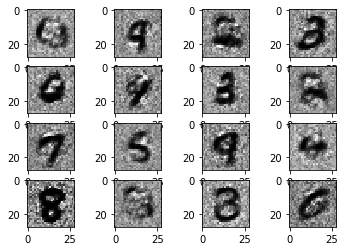

Epoch: 95
	Batch: 1	Discriminator Error: 0.277431	Generator Error: 3.797812
	Batch: 100	Discriminator Error: 0.361699	Generator Error: 3.892915
	Batch: 200	Discriminator Error: 0.428948	Generator Error: 3.611014
	Batch: 300	Discriminator Error: 0.247438	Generator Error: 4.318930
	Batch: 400	Discriminator Error: 0.208128	Generator Error: 3.582023
	Batch: 500	Discriminator Error: 0.262637	Generator Error: 4.243985
	Batch: 600	Discriminator Error: 0.147344	Generator Error: 3.798496


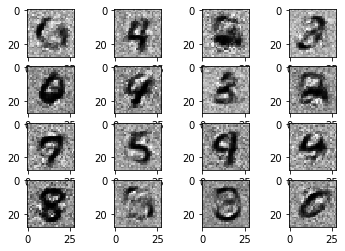

Epoch: 96
	Batch: 1	Discriminator Error: 0.294666	Generator Error: 3.519295
	Batch: 100	Discriminator Error: 0.268656	Generator Error: 3.971318
	Batch: 200	Discriminator Error: 0.456083	Generator Error: 3.662256
	Batch: 300	Discriminator Error: 0.250452	Generator Error: 3.973492
	Batch: 400	Discriminator Error: 0.183910	Generator Error: 4.366311
	Batch: 500	Discriminator Error: 0.421256	Generator Error: 3.787763
	Batch: 600	Discriminator Error: 0.363954	Generator Error: 3.924693


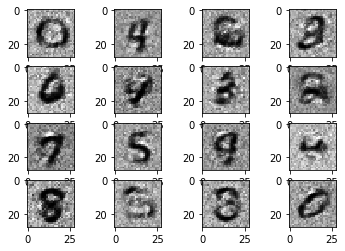

Epoch: 97
	Batch: 1	Discriminator Error: 0.338176	Generator Error: 3.481615
	Batch: 100	Discriminator Error: 0.370880	Generator Error: 3.940442
	Batch: 200	Discriminator Error: 0.325049	Generator Error: 3.663967
	Batch: 300	Discriminator Error: 0.393652	Generator Error: 3.391335
	Batch: 400	Discriminator Error: 0.399323	Generator Error: 3.257314
	Batch: 500	Discriminator Error: 0.304686	Generator Error: 3.536846
	Batch: 600	Discriminator Error: 0.318104	Generator Error: 4.193403


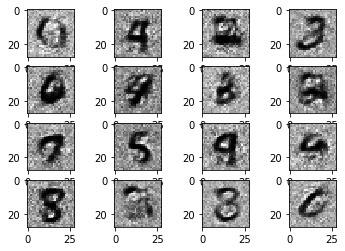

Epoch: 98
	Batch: 1	Discriminator Error: 0.239460	Generator Error: 3.890599
	Batch: 100	Discriminator Error: 0.272273	Generator Error: 3.767291
	Batch: 200	Discriminator Error: 0.238369	Generator Error: 3.336460
	Batch: 300	Discriminator Error: 0.272366	Generator Error: 3.560707
	Batch: 400	Discriminator Error: 0.210933	Generator Error: 3.554914
	Batch: 500	Discriminator Error: 0.334532	Generator Error: 3.904953
	Batch: 600	Discriminator Error: 0.393053	Generator Error: 3.868367


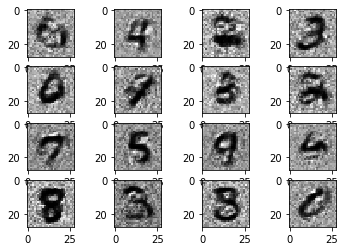

Epoch: 99
	Batch: 1	Discriminator Error: 0.340220	Generator Error: 3.846700
	Batch: 100	Discriminator Error: 0.270909	Generator Error: 3.717610
	Batch: 200	Discriminator Error: 0.302795	Generator Error: 4.132948
	Batch: 300	Discriminator Error: 0.317812	Generator Error: 3.433445
	Batch: 400	Discriminator Error: 0.270390	Generator Error: 3.717632
	Batch: 500	Discriminator Error: 0.375858	Generator Error: 4.428414
	Batch: 600	Discriminator Error: 0.252176	Generator Error: 4.033863


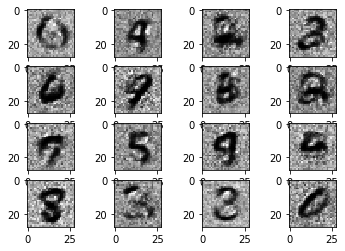

Epoch: 100
	Batch: 1	Discriminator Error: 0.319605	Generator Error: 3.615509
	Batch: 100	Discriminator Error: 0.312387	Generator Error: 3.780276
	Batch: 200	Discriminator Error: 0.318563	Generator Error: 3.268539
	Batch: 300	Discriminator Error: 0.236288	Generator Error: 3.640364
	Batch: 400	Discriminator Error: 0.271548	Generator Error: 3.772932
	Batch: 500	Discriminator Error: 0.266955	Generator Error: 3.755423
	Batch: 600	Discriminator Error: 0.292249	Generator Error: 4.057729


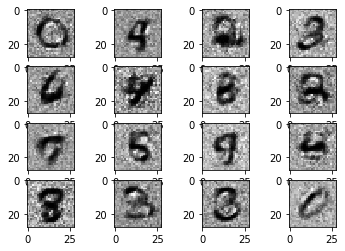

Epoch: 101
	Batch: 1	Discriminator Error: 0.317671	Generator Error: 4.182099
	Batch: 100	Discriminator Error: 0.392946	Generator Error: 3.837298
	Batch: 200	Discriminator Error: 0.366639	Generator Error: 3.558276
	Batch: 300	Discriminator Error: 0.485706	Generator Error: 3.217947
	Batch: 400	Discriminator Error: 0.349217	Generator Error: 4.038734
	Batch: 500	Discriminator Error: 0.275962	Generator Error: 3.917804
	Batch: 600	Discriminator Error: 0.322264	Generator Error: 4.020431


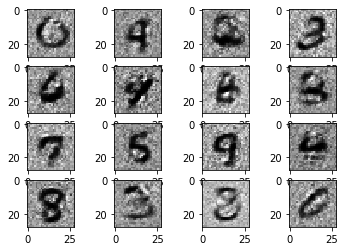

Epoch: 102
	Batch: 1	Discriminator Error: 0.449049	Generator Error: 4.019160
	Batch: 100	Discriminator Error: 0.260132	Generator Error: 3.854620
	Batch: 200	Discriminator Error: 0.371445	Generator Error: 3.695204
	Batch: 300	Discriminator Error: 0.248348	Generator Error: 4.132920
	Batch: 400	Discriminator Error: 0.361207	Generator Error: 3.329259
	Batch: 500	Discriminator Error: 0.269009	Generator Error: 4.057913
	Batch: 600	Discriminator Error: 0.303068	Generator Error: 4.043769


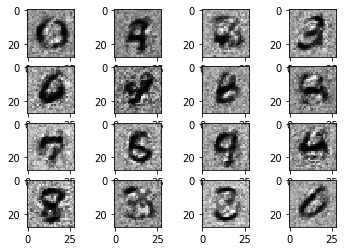

Epoch: 103
	Batch: 1	Discriminator Error: 0.301042	Generator Error: 4.120902
	Batch: 100	Discriminator Error: 0.344133	Generator Error: 4.143555
	Batch: 200	Discriminator Error: 0.341747	Generator Error: 3.721677
	Batch: 300	Discriminator Error: 0.260690	Generator Error: 4.125292
	Batch: 400	Discriminator Error: 0.394780	Generator Error: 3.815135
	Batch: 500	Discriminator Error: 0.259027	Generator Error: 3.692401
	Batch: 600	Discriminator Error: 0.205549	Generator Error: 4.000721


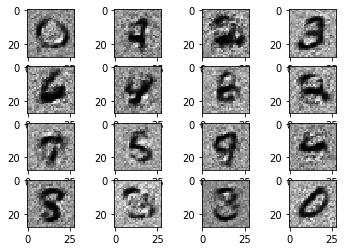

Epoch: 104
	Batch: 1	Discriminator Error: 0.242773	Generator Error: 3.684075
	Batch: 100	Discriminator Error: 0.368164	Generator Error: 3.893183
	Batch: 200	Discriminator Error: 0.267610	Generator Error: 3.475695
	Batch: 300	Discriminator Error: 0.378759	Generator Error: 3.356310
	Batch: 400	Discriminator Error: 0.214809	Generator Error: 3.477566
	Batch: 500	Discriminator Error: 0.384473	Generator Error: 3.292708
	Batch: 600	Discriminator Error: 0.498173	Generator Error: 3.563361


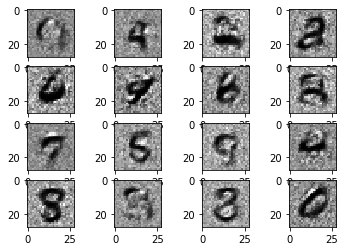

Epoch: 105
	Batch: 1	Discriminator Error: 0.361403	Generator Error: 3.390479
	Batch: 100	Discriminator Error: 0.373022	Generator Error: 4.086032
	Batch: 200	Discriminator Error: 0.246712	Generator Error: 4.292405
	Batch: 300	Discriminator Error: 0.240898	Generator Error: 4.317729
	Batch: 400	Discriminator Error: 0.320353	Generator Error: 4.082720
	Batch: 500	Discriminator Error: 0.292003	Generator Error: 4.386209
	Batch: 600	Discriminator Error: 0.459164	Generator Error: 3.664284


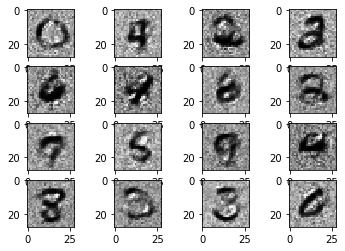

Epoch: 106
	Batch: 1	Discriminator Error: 0.350076	Generator Error: 4.074129
	Batch: 100	Discriminator Error: 0.296585	Generator Error: 3.726062
	Batch: 200	Discriminator Error: 0.299361	Generator Error: 4.182910
	Batch: 300	Discriminator Error: 0.367547	Generator Error: 3.791330
	Batch: 400	Discriminator Error: 0.287731	Generator Error: 4.242682
	Batch: 500	Discriminator Error: 0.223662	Generator Error: 4.083810
	Batch: 600	Discriminator Error: 0.449829	Generator Error: 3.690437


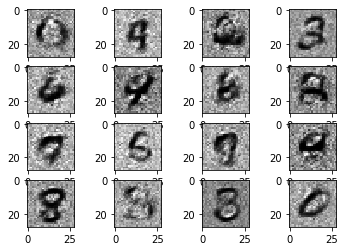

Epoch: 107
	Batch: 1	Discriminator Error: 0.391394	Generator Error: 3.734693
	Batch: 100	Discriminator Error: 0.217118	Generator Error: 4.452350
	Batch: 200	Discriminator Error: 0.261338	Generator Error: 3.743438
	Batch: 300	Discriminator Error: 0.245461	Generator Error: 3.242995
	Batch: 400	Discriminator Error: 0.184787	Generator Error: 3.927814
	Batch: 500	Discriminator Error: 0.447364	Generator Error: 3.571877
	Batch: 600	Discriminator Error: 0.317252	Generator Error: 3.711661


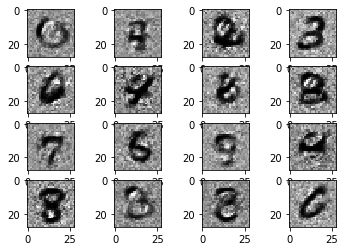

Epoch: 108
	Batch: 1	Discriminator Error: 0.283411	Generator Error: 3.709969
	Batch: 100	Discriminator Error: 0.313497	Generator Error: 3.482290
	Batch: 200	Discriminator Error: 0.380100	Generator Error: 3.503592
	Batch: 300	Discriminator Error: 0.332527	Generator Error: 3.466902
	Batch: 400	Discriminator Error: 0.239257	Generator Error: 4.033372
	Batch: 500	Discriminator Error: 0.288699	Generator Error: 3.606351
	Batch: 600	Discriminator Error: 0.462477	Generator Error: 3.506576


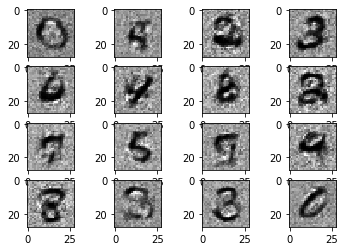

Epoch: 109
	Batch: 1	Discriminator Error: 0.298200	Generator Error: 3.581840
	Batch: 100	Discriminator Error: 0.423985	Generator Error: 3.702647
	Batch: 200	Discriminator Error: 0.339139	Generator Error: 3.927089
	Batch: 300	Discriminator Error: 0.357877	Generator Error: 3.304031
	Batch: 400	Discriminator Error: 0.233187	Generator Error: 3.994278
	Batch: 500	Discriminator Error: 0.303329	Generator Error: 3.876869
	Batch: 600	Discriminator Error: 0.387279	Generator Error: 4.186947


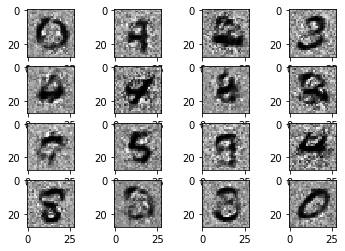

Epoch: 110
	Batch: 1	Discriminator Error: 0.434358	Generator Error: 4.223405
	Batch: 100	Discriminator Error: 0.277130	Generator Error: 3.596023
	Batch: 200	Discriminator Error: 0.351335	Generator Error: 4.109812
	Batch: 300	Discriminator Error: 0.362361	Generator Error: 3.946988
	Batch: 400	Discriminator Error: 0.256049	Generator Error: 3.634044
	Batch: 500	Discriminator Error: 0.332088	Generator Error: 3.939065
	Batch: 600	Discriminator Error: 0.255332	Generator Error: 3.762809


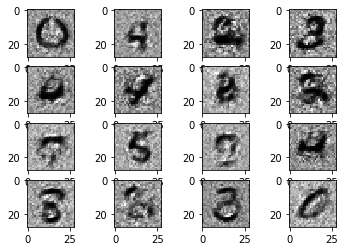

Epoch: 111
	Batch: 1	Discriminator Error: 0.352599	Generator Error: 3.795803
	Batch: 100	Discriminator Error: 0.298140	Generator Error: 3.929996
	Batch: 200	Discriminator Error: 0.251752	Generator Error: 3.219620
	Batch: 300	Discriminator Error: 0.327626	Generator Error: 3.962414
	Batch: 400	Discriminator Error: 0.319167	Generator Error: 3.469547
	Batch: 500	Discriminator Error: 0.366186	Generator Error: 3.497587
	Batch: 600	Discriminator Error: 0.302172	Generator Error: 3.383813


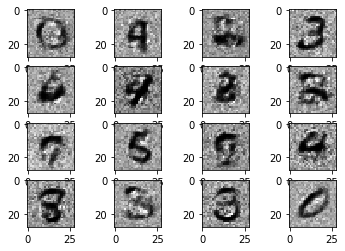

Epoch: 112
	Batch: 1	Discriminator Error: 0.266147	Generator Error: 3.754452
	Batch: 100	Discriminator Error: 0.420471	Generator Error: 3.672321
	Batch: 200	Discriminator Error: 0.365829	Generator Error: 3.491788
	Batch: 300	Discriminator Error: 0.293315	Generator Error: 3.348682
	Batch: 400	Discriminator Error: 0.245265	Generator Error: 3.140726
	Batch: 500	Discriminator Error: 0.306957	Generator Error: 4.051190
	Batch: 600	Discriminator Error: 0.209455	Generator Error: 4.581520


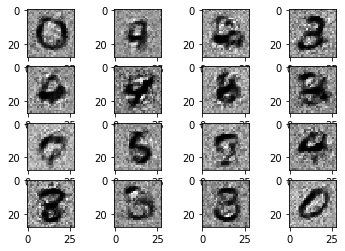

Epoch: 113
	Batch: 1	Discriminator Error: 0.425066	Generator Error: 4.882539
	Batch: 100	Discriminator Error: 0.352880	Generator Error: 3.831094
	Batch: 200	Discriminator Error: 0.391574	Generator Error: 3.657434
	Batch: 300	Discriminator Error: 0.320557	Generator Error: 3.709064
	Batch: 400	Discriminator Error: 0.265294	Generator Error: 3.917853
	Batch: 500	Discriminator Error: 0.415665	Generator Error: 4.355031
	Batch: 600	Discriminator Error: 0.366208	Generator Error: 3.780911


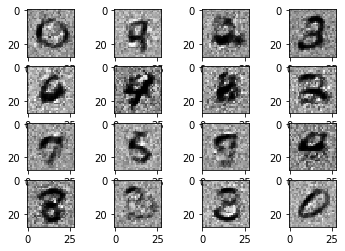

Epoch: 114
	Batch: 1	Discriminator Error: 0.283846	Generator Error: 3.820714
	Batch: 100	Discriminator Error: 0.277623	Generator Error: 3.683190
	Batch: 200	Discriminator Error: 0.415501	Generator Error: 3.503095
	Batch: 300	Discriminator Error: 0.330128	Generator Error: 3.878186
	Batch: 400	Discriminator Error: 0.299280	Generator Error: 3.687948
	Batch: 500	Discriminator Error: 0.296149	Generator Error: 3.543023
	Batch: 600	Discriminator Error: 0.428585	Generator Error: 3.338346


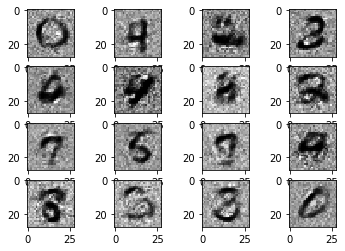

Epoch: 115
	Batch: 1	Discriminator Error: 0.296443	Generator Error: 3.296194
	Batch: 100	Discriminator Error: 0.365570	Generator Error: 4.371425
	Batch: 200	Discriminator Error: 0.277508	Generator Error: 3.870794
	Batch: 300	Discriminator Error: 0.339902	Generator Error: 3.475064
	Batch: 400	Discriminator Error: 0.451602	Generator Error: 3.925906
	Batch: 500	Discriminator Error: 0.245194	Generator Error: 4.237530
	Batch: 600	Discriminator Error: 0.369268	Generator Error: 3.786536


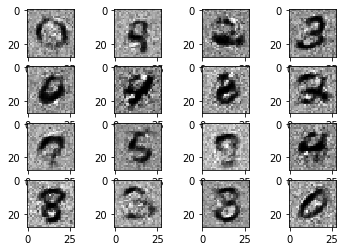

Epoch: 116
	Batch: 1	Discriminator Error: 0.423345	Generator Error: 3.863123
	Batch: 100	Discriminator Error: 0.371564	Generator Error: 3.498099
	Batch: 200	Discriminator Error: 0.286453	Generator Error: 3.779851
	Batch: 300	Discriminator Error: 0.279088	Generator Error: 4.026706
	Batch: 400	Discriminator Error: 0.326006	Generator Error: 3.669178
	Batch: 500	Discriminator Error: 0.264583	Generator Error: 3.024218
	Batch: 600	Discriminator Error: 0.215134	Generator Error: 3.437991


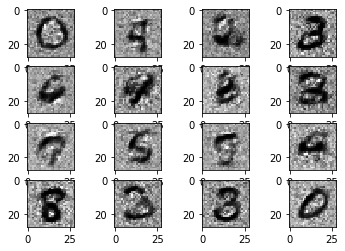

Epoch: 117
	Batch: 1	Discriminator Error: 0.286662	Generator Error: 3.517335
	Batch: 100	Discriminator Error: 0.434512	Generator Error: 3.304176
	Batch: 200	Discriminator Error: 0.358877	Generator Error: 3.906470
	Batch: 300	Discriminator Error: 0.318901	Generator Error: 3.674117
	Batch: 400	Discriminator Error: 0.298066	Generator Error: 3.941543
	Batch: 500	Discriminator Error: 0.264927	Generator Error: 3.716542
	Batch: 600	Discriminator Error: 0.264942	Generator Error: 3.758477


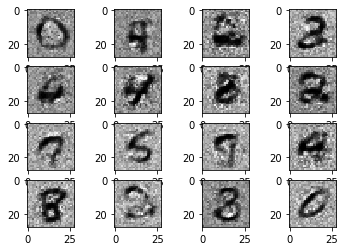

Epoch: 118
	Batch: 1	Discriminator Error: 0.303223	Generator Error: 3.881779
	Batch: 100	Discriminator Error: 0.393299	Generator Error: 4.105396
	Batch: 200	Discriminator Error: 0.389201	Generator Error: 3.577710
	Batch: 300	Discriminator Error: 0.342217	Generator Error: 3.762601
	Batch: 400	Discriminator Error: 0.346818	Generator Error: 3.583930
	Batch: 500	Discriminator Error: 0.302894	Generator Error: 3.664597
	Batch: 600	Discriminator Error: 0.319756	Generator Error: 3.920533


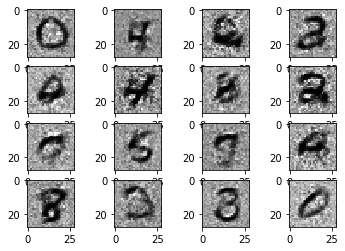

Epoch: 119
	Batch: 1	Discriminator Error: 0.274233	Generator Error: 3.956716
	Batch: 100	Discriminator Error: 0.258248	Generator Error: 3.760851
	Batch: 200	Discriminator Error: 0.437652	Generator Error: 3.716804
	Batch: 300	Discriminator Error: 0.287586	Generator Error: 3.565445
	Batch: 400	Discriminator Error: 0.221214	Generator Error: 3.979543
	Batch: 500	Discriminator Error: 0.240798	Generator Error: 3.866323
	Batch: 600	Discriminator Error: 0.350407	Generator Error: 3.632773


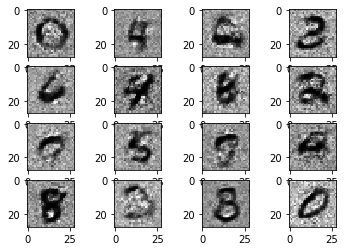

Epoch: 120
	Batch: 1	Discriminator Error: 0.279848	Generator Error: 4.150224
	Batch: 100	Discriminator Error: 0.381200	Generator Error: 3.534654
	Batch: 200	Discriminator Error: 0.369264	Generator Error: 3.878540
	Batch: 300	Discriminator Error: 0.244537	Generator Error: 3.891925
	Batch: 400	Discriminator Error: 0.434719	Generator Error: 3.277410
	Batch: 500	Discriminator Error: 0.240452	Generator Error: 4.028122
	Batch: 600	Discriminator Error: 0.537649	Generator Error: 3.508457


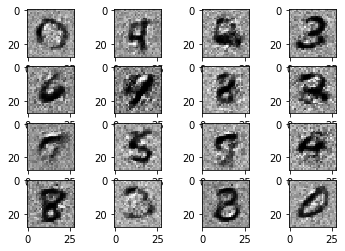

Epoch: 121
	Batch: 1	Discriminator Error: 0.452042	Generator Error: 3.779145
	Batch: 100	Discriminator Error: 0.401261	Generator Error: 3.224698
	Batch: 200	Discriminator Error: 0.514665	Generator Error: 3.259388
	Batch: 300	Discriminator Error: 0.332861	Generator Error: 4.043605
	Batch: 400	Discriminator Error: 0.331214	Generator Error: 3.678997
	Batch: 500	Discriminator Error: 0.358019	Generator Error: 4.385107
	Batch: 600	Discriminator Error: 0.335319	Generator Error: 3.513750


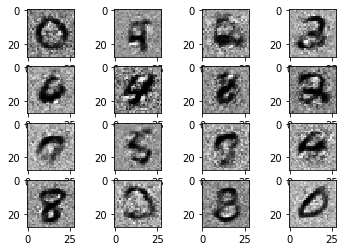

Epoch: 122
	Batch: 1	Discriminator Error: 0.329851	Generator Error: 3.857467
	Batch: 100	Discriminator Error: 0.275888	Generator Error: 3.710231
	Batch: 200	Discriminator Error: 0.425438	Generator Error: 3.938191
	Batch: 300	Discriminator Error: 0.471833	Generator Error: 3.708188
	Batch: 400	Discriminator Error: 0.358533	Generator Error: 3.406938
	Batch: 500	Discriminator Error: 0.272183	Generator Error: 3.932572
	Batch: 600	Discriminator Error: 0.374519	Generator Error: 3.593354


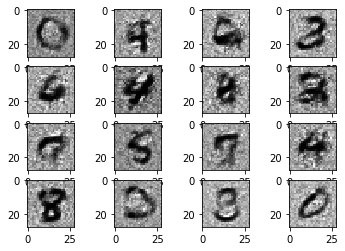

Epoch: 123
	Batch: 1	Discriminator Error: 0.277714	Generator Error: 3.748004
	Batch: 100	Discriminator Error: 0.352419	Generator Error: 3.897233
	Batch: 200	Discriminator Error: 0.208147	Generator Error: 3.511834
	Batch: 300	Discriminator Error: 0.324450	Generator Error: 3.655468
	Batch: 400	Discriminator Error: 0.272136	Generator Error: 3.604080
	Batch: 500	Discriminator Error: 0.362264	Generator Error: 4.259203
	Batch: 600	Discriminator Error: 0.481968	Generator Error: 4.394485


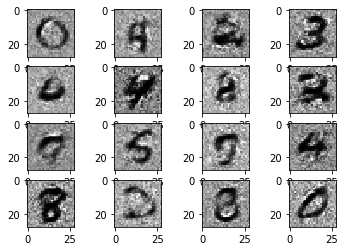

Epoch: 124
	Batch: 1	Discriminator Error: 0.233241	Generator Error: 4.325923
	Batch: 100	Discriminator Error: 0.309482	Generator Error: 4.135343
	Batch: 200	Discriminator Error: 0.270810	Generator Error: 3.443843
	Batch: 300	Discriminator Error: 0.259946	Generator Error: 3.881428
	Batch: 400	Discriminator Error: 0.447056	Generator Error: 3.703107
	Batch: 500	Discriminator Error: 0.295010	Generator Error: 3.461898
	Batch: 600	Discriminator Error: 0.404838	Generator Error: 3.743223


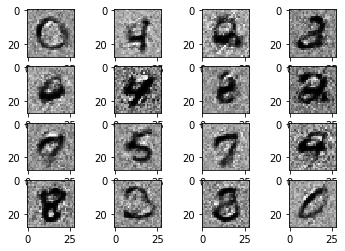

Epoch: 125
	Batch: 1	Discriminator Error: 0.374374	Generator Error: 3.765659
	Batch: 100	Discriminator Error: 0.287451	Generator Error: 3.504224
	Batch: 200	Discriminator Error: 0.550784	Generator Error: 3.980942
	Batch: 300	Discriminator Error: 0.384872	Generator Error: 3.203442
	Batch: 400	Discriminator Error: 0.314653	Generator Error: 3.636891
	Batch: 500	Discriminator Error: 0.329944	Generator Error: 3.868393
	Batch: 600	Discriminator Error: 0.205732	Generator Error: 3.984222


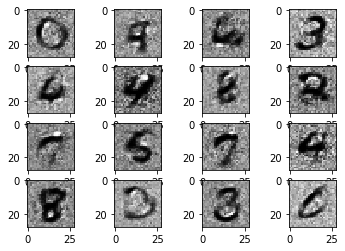

Epoch: 126
	Batch: 1	Discriminator Error: 0.407927	Generator Error: 4.089276
	Batch: 100	Discriminator Error: 0.298684	Generator Error: 3.664902
	Batch: 200	Discriminator Error: 0.257147	Generator Error: 3.632977
	Batch: 300	Discriminator Error: 0.354834	Generator Error: 3.559513
	Batch: 400	Discriminator Error: 0.258338	Generator Error: 3.074198
	Batch: 500	Discriminator Error: 0.230144	Generator Error: 3.648192
	Batch: 600	Discriminator Error: 0.154918	Generator Error: 3.788630


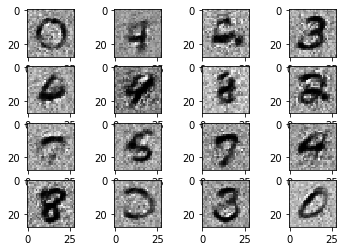

Epoch: 127
	Batch: 1	Discriminator Error: 0.206732	Generator Error: 4.075550
	Batch: 100	Discriminator Error: 0.233587	Generator Error: 3.539037
	Batch: 200	Discriminator Error: 0.327415	Generator Error: 3.559525
	Batch: 300	Discriminator Error: 0.352208	Generator Error: 3.426545
	Batch: 400	Discriminator Error: 0.289002	Generator Error: 3.892224
	Batch: 500	Discriminator Error: 0.420584	Generator Error: 3.824080
	Batch: 600	Discriminator Error: 0.271208	Generator Error: 3.240417


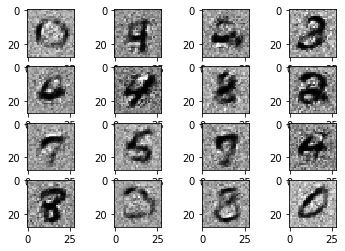

Epoch: 128
	Batch: 1	Discriminator Error: 0.236795	Generator Error: 3.771588
	Batch: 100	Discriminator Error: 0.342501	Generator Error: 3.594943
	Batch: 200	Discriminator Error: 0.230818	Generator Error: 4.161241
	Batch: 300	Discriminator Error: 0.229715	Generator Error: 4.144361
	Batch: 400	Discriminator Error: 0.287213	Generator Error: 3.734651
	Batch: 500	Discriminator Error: 0.411034	Generator Error: 3.366659
	Batch: 600	Discriminator Error: 0.339014	Generator Error: 3.414576


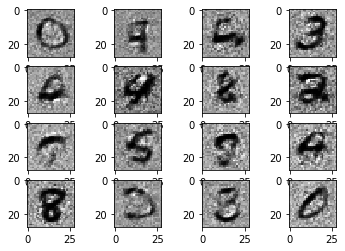

Epoch: 129
	Batch: 1	Discriminator Error: 0.248933	Generator Error: 3.416833
	Batch: 100	Discriminator Error: 0.371419	Generator Error: 3.336757
	Batch: 200	Discriminator Error: 0.387744	Generator Error: 4.331038
	Batch: 300	Discriminator Error: 0.300609	Generator Error: 4.489935
	Batch: 400	Discriminator Error: 0.359795	Generator Error: 3.623773
	Batch: 500	Discriminator Error: 0.361617	Generator Error: 3.753063
	Batch: 600	Discriminator Error: 0.331616	Generator Error: 4.098856


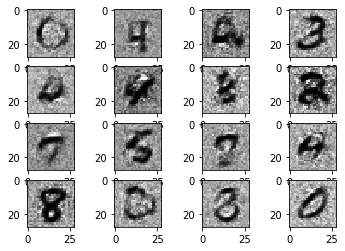

Epoch: 130
	Batch: 1	Discriminator Error: 0.336164	Generator Error: 3.933367
	Batch: 100	Discriminator Error: 0.356304	Generator Error: 3.495603
	Batch: 200	Discriminator Error: 0.250363	Generator Error: 3.509136
	Batch: 300	Discriminator Error: 0.283123	Generator Error: 3.584779
	Batch: 400	Discriminator Error: 0.260358	Generator Error: 4.042341
	Batch: 500	Discriminator Error: 0.324996	Generator Error: 3.660163
	Batch: 600	Discriminator Error: 0.358120	Generator Error: 3.730913


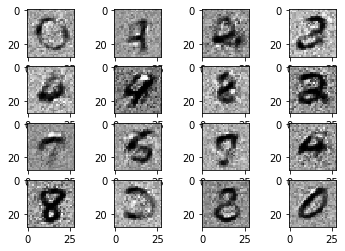

Epoch: 131
	Batch: 1	Discriminator Error: 0.452634	Generator Error: 3.945574
	Batch: 100	Discriminator Error: 0.330808	Generator Error: 4.172063
	Batch: 200	Discriminator Error: 0.338278	Generator Error: 3.597520
	Batch: 300	Discriminator Error: 0.402611	Generator Error: 3.316853
	Batch: 400	Discriminator Error: 0.386837	Generator Error: 3.731008
	Batch: 500	Discriminator Error: 0.269303	Generator Error: 3.364656
	Batch: 600	Discriminator Error: 0.326430	Generator Error: 3.288126


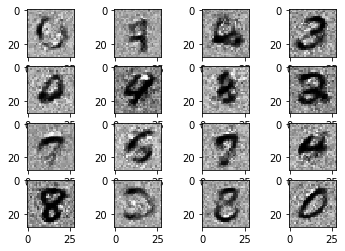

Epoch: 132
	Batch: 1	Discriminator Error: 0.333169	Generator Error: 3.624884
	Batch: 100	Discriminator Error: 0.283618	Generator Error: 4.102547
	Batch: 200	Discriminator Error: 0.414663	Generator Error: 4.291246
	Batch: 300	Discriminator Error: 0.215003	Generator Error: 3.776324
	Batch: 400	Discriminator Error: 0.243796	Generator Error: 4.145035
	Batch: 500	Discriminator Error: 0.411445	Generator Error: 3.541398
	Batch: 600	Discriminator Error: 0.335783	Generator Error: 3.572716


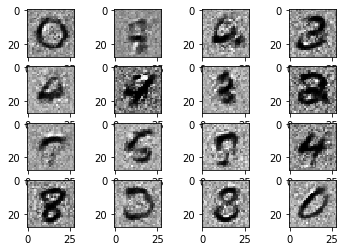

Epoch: 133
	Batch: 1	Discriminator Error: 0.363205	Generator Error: 3.229420
	Batch: 100	Discriminator Error: 0.267620	Generator Error: 4.314023
	Batch: 200	Discriminator Error: 0.610402	Generator Error: 3.678223
	Batch: 300	Discriminator Error: 0.454687	Generator Error: 3.736750
	Batch: 400	Discriminator Error: 0.394798	Generator Error: 4.064592
	Batch: 500	Discriminator Error: 0.356786	Generator Error: 4.178740
	Batch: 600	Discriminator Error: 0.210264	Generator Error: 4.352468


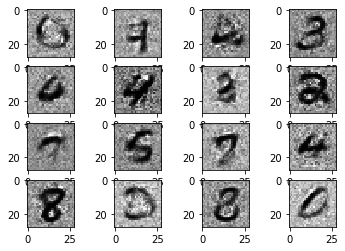

Epoch: 134
	Batch: 1	Discriminator Error: 0.422572	Generator Error: 4.230184
	Batch: 100	Discriminator Error: 0.197927	Generator Error: 3.796413
	Batch: 200	Discriminator Error: 0.176689	Generator Error: 3.698217
	Batch: 300	Discriminator Error: 0.550263	Generator Error: 4.132211
	Batch: 400	Discriminator Error: 0.374408	Generator Error: 3.260571
	Batch: 500	Discriminator Error: 0.330121	Generator Error: 3.724757
	Batch: 600	Discriminator Error: 0.373845	Generator Error: 3.914044


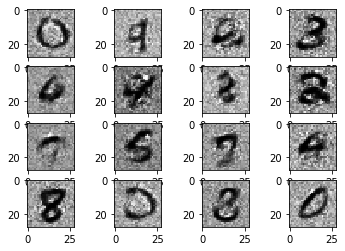

Epoch: 135
	Batch: 1	Discriminator Error: 0.291788	Generator Error: 3.792365
	Batch: 100	Discriminator Error: 0.384505	Generator Error: 3.826413
	Batch: 200	Discriminator Error: 0.370323	Generator Error: 3.575197
	Batch: 300	Discriminator Error: 0.379384	Generator Error: 3.887967
	Batch: 400	Discriminator Error: 0.250686	Generator Error: 3.663568
	Batch: 500	Discriminator Error: 0.242461	Generator Error: 2.872320
	Batch: 600	Discriminator Error: 0.364307	Generator Error: 3.672813


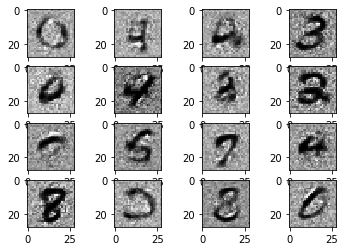

Epoch: 136
	Batch: 1	Discriminator Error: 0.326533	Generator Error: 3.532282
	Batch: 100	Discriminator Error: 0.376789	Generator Error: 3.608052
	Batch: 200	Discriminator Error: 0.224997	Generator Error: 3.666627
	Batch: 300	Discriminator Error: 0.306827	Generator Error: 3.652618
	Batch: 400	Discriminator Error: 0.335337	Generator Error: 3.592844
	Batch: 500	Discriminator Error: 0.308624	Generator Error: 3.763608
	Batch: 600	Discriminator Error: 0.396032	Generator Error: 3.494052


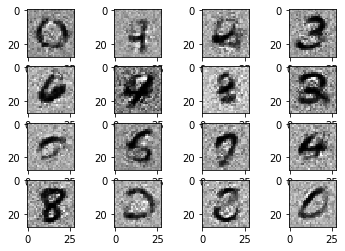

Epoch: 137
	Batch: 1	Discriminator Error: 0.279498	Generator Error: 3.218987
	Batch: 100	Discriminator Error: 0.308256	Generator Error: 3.509073
	Batch: 200	Discriminator Error: 0.280004	Generator Error: 3.474443
	Batch: 300	Discriminator Error: 0.317150	Generator Error: 4.118655
	Batch: 400	Discriminator Error: 0.333887	Generator Error: 3.801939
	Batch: 500	Discriminator Error: 0.326481	Generator Error: 3.492599
	Batch: 600	Discriminator Error: 0.413817	Generator Error: 3.897511


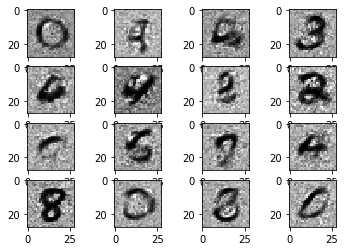

Epoch: 138
	Batch: 1	Discriminator Error: 0.323451	Generator Error: 3.277213
	Batch: 100	Discriminator Error: 0.330946	Generator Error: 3.536209
	Batch: 200	Discriminator Error: 0.355924	Generator Error: 3.757460
	Batch: 300	Discriminator Error: 0.325235	Generator Error: 3.786217
	Batch: 400	Discriminator Error: 0.309105	Generator Error: 4.019760
	Batch: 500	Discriminator Error: 0.451420	Generator Error: 3.088119
	Batch: 600	Discriminator Error: 0.377677	Generator Error: 3.149247


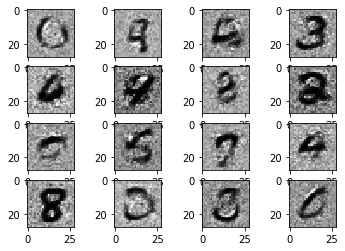

Epoch: 139
	Batch: 1	Discriminator Error: 0.362268	Generator Error: 3.448572
	Batch: 100	Discriminator Error: 0.352778	Generator Error: 2.919392
	Batch: 200	Discriminator Error: 0.358901	Generator Error: 3.349877
	Batch: 300	Discriminator Error: 0.249397	Generator Error: 3.696718
	Batch: 400	Discriminator Error: 0.268236	Generator Error: 4.124812
	Batch: 500	Discriminator Error: 0.418077	Generator Error: 3.662824
	Batch: 600	Discriminator Error: 0.357961	Generator Error: 4.038942


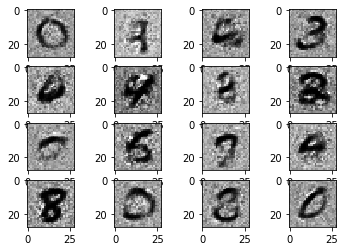

Epoch: 140
	Batch: 1	Discriminator Error: 0.402729	Generator Error: 4.177078
	Batch: 100	Discriminator Error: 0.390974	Generator Error: 3.340853
	Batch: 200	Discriminator Error: 0.386036	Generator Error: 3.719064
	Batch: 300	Discriminator Error: 0.264008	Generator Error: 3.837599
	Batch: 400	Discriminator Error: 0.389141	Generator Error: 3.752370
	Batch: 500	Discriminator Error: 0.356371	Generator Error: 3.546751
	Batch: 600	Discriminator Error: 0.403459	Generator Error: 3.973280


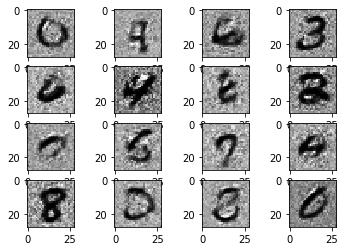

Epoch: 141
	Batch: 1	Discriminator Error: 0.324555	Generator Error: 4.123187
	Batch: 100	Discriminator Error: 0.385025	Generator Error: 3.468457
	Batch: 200	Discriminator Error: 0.465579	Generator Error: 3.743061
	Batch: 300	Discriminator Error: 0.274053	Generator Error: 3.547921
	Batch: 400	Discriminator Error: 0.366040	Generator Error: 3.808269
	Batch: 500	Discriminator Error: 0.363525	Generator Error: 3.524837
	Batch: 600	Discriminator Error: 0.365378	Generator Error: 3.716268


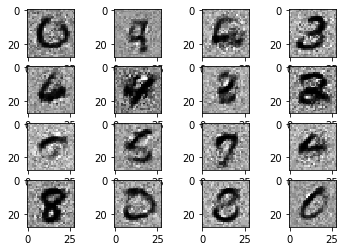

Epoch: 142
	Batch: 1	Discriminator Error: 0.463437	Generator Error: 3.687086
	Batch: 100	Discriminator Error: 0.268877	Generator Error: 3.722943
	Batch: 200	Discriminator Error: 0.341468	Generator Error: 3.232444
	Batch: 300	Discriminator Error: 0.233619	Generator Error: 3.717037
	Batch: 400	Discriminator Error: 0.320509	Generator Error: 3.374107
	Batch: 500	Discriminator Error: 0.403210	Generator Error: 3.405099
	Batch: 600	Discriminator Error: 0.333445	Generator Error: 3.669232


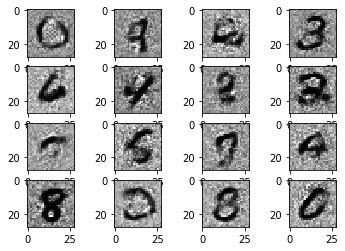

Epoch: 143
	Batch: 1	Discriminator Error: 0.273292	Generator Error: 3.541955
	Batch: 100	Discriminator Error: 0.371175	Generator Error: 3.407580
	Batch: 200	Discriminator Error: 0.289805	Generator Error: 3.517107
	Batch: 300	Discriminator Error: 0.237961	Generator Error: 3.651912
	Batch: 400	Discriminator Error: 0.385480	Generator Error: 4.047249
	Batch: 500	Discriminator Error: 0.421509	Generator Error: 3.590429
	Batch: 600	Discriminator Error: 0.433831	Generator Error: 4.307066


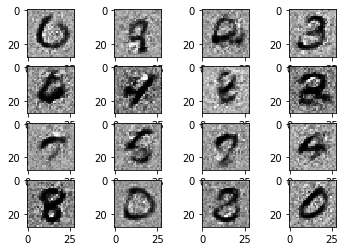

Epoch: 144
	Batch: 1	Discriminator Error: 0.253340	Generator Error: 3.900667
	Batch: 100	Discriminator Error: 0.290840	Generator Error: 3.195331
	Batch: 200	Discriminator Error: 0.320000	Generator Error: 3.749625
	Batch: 300	Discriminator Error: 0.386882	Generator Error: 3.520171
	Batch: 400	Discriminator Error: 0.469190	Generator Error: 3.429815
	Batch: 500	Discriminator Error: 0.251190	Generator Error: 4.020939
	Batch: 600	Discriminator Error: 0.355032	Generator Error: 3.601586


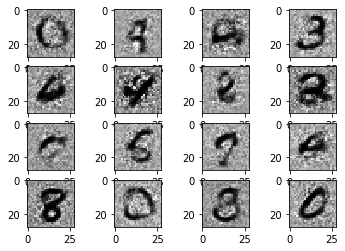

Epoch: 145
	Batch: 1	Discriminator Error: 0.349956	Generator Error: 3.872476
	Batch: 100	Discriminator Error: 0.283085	Generator Error: 3.345631
	Batch: 200	Discriminator Error: 0.289663	Generator Error: 3.615452
	Batch: 300	Discriminator Error: 0.390705	Generator Error: 3.621369
	Batch: 400	Discriminator Error: 0.393230	Generator Error: 3.443638
	Batch: 500	Discriminator Error: 0.331084	Generator Error: 3.033633
	Batch: 600	Discriminator Error: 0.357665	Generator Error: 3.590446


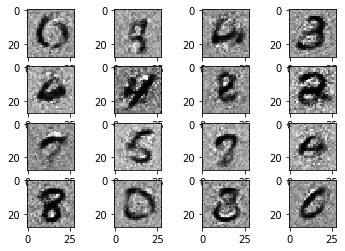

Epoch: 146
	Batch: 1	Discriminator Error: 0.370254	Generator Error: 3.802656
	Batch: 100	Discriminator Error: 0.282988	Generator Error: 3.388826
	Batch: 200	Discriminator Error: 0.185110	Generator Error: 3.541338
	Batch: 300	Discriminator Error: 0.333115	Generator Error: 3.769429
	Batch: 400	Discriminator Error: 0.374730	Generator Error: 3.923478
	Batch: 500	Discriminator Error: 0.390286	Generator Error: 3.222157
	Batch: 600	Discriminator Error: 0.359681	Generator Error: 3.313433


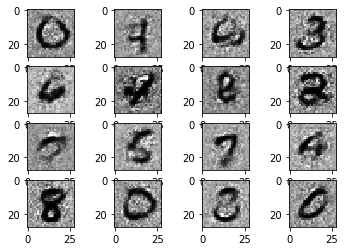

Epoch: 147
	Batch: 1	Discriminator Error: 0.425402	Generator Error: 3.383524
	Batch: 100	Discriminator Error: 0.328461	Generator Error: 3.788761
	Batch: 200	Discriminator Error: 0.464192	Generator Error: 3.800718
	Batch: 300	Discriminator Error: 0.388030	Generator Error: 3.210577
	Batch: 400	Discriminator Error: 0.449864	Generator Error: 3.209138
	Batch: 500	Discriminator Error: 0.432900	Generator Error: 3.280095
	Batch: 600	Discriminator Error: 0.372581	Generator Error: 3.747062


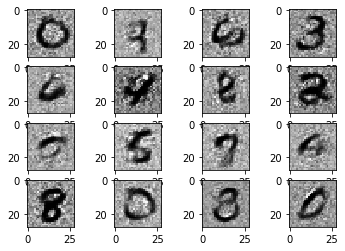

Epoch: 148
	Batch: 1	Discriminator Error: 0.359907	Generator Error: 3.928773
	Batch: 100	Discriminator Error: 0.249217	Generator Error: 4.019977
	Batch: 200	Discriminator Error: 0.461729	Generator Error: 3.170191
	Batch: 300	Discriminator Error: 0.315751	Generator Error: 3.825744
	Batch: 400	Discriminator Error: 0.383041	Generator Error: 3.422840
	Batch: 500	Discriminator Error: 0.353813	Generator Error: 3.884111
	Batch: 600	Discriminator Error: 0.382461	Generator Error: 3.684201


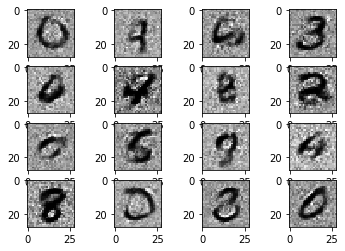

Epoch: 149
	Batch: 1	Discriminator Error: 0.350806	Generator Error: 3.633378
	Batch: 100	Discriminator Error: 0.432141	Generator Error: 3.411151
	Batch: 200	Discriminator Error: 0.311704	Generator Error: 3.921484
	Batch: 300	Discriminator Error: 0.285165	Generator Error: 3.941047
	Batch: 400	Discriminator Error: 0.311735	Generator Error: 3.363226
	Batch: 500	Discriminator Error: 0.239180	Generator Error: 4.347423
	Batch: 600	Discriminator Error: 0.237012	Generator Error: 3.465145


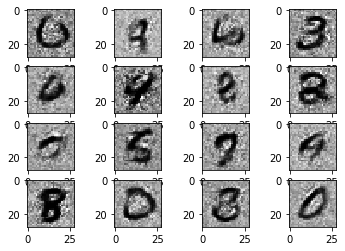

In [15]:
# Train both the networks simultaneously

epochs = 150

for epoch in range(epochs):
    print("Epoch: %d" %(epoch))
    for n_batch, (real_batch,_) in enumerate(dataloader_mnist_train):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = real_batch.reshape(batch_size,784)
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = gen(noise(batch_size))
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(optimizer_d, criterion_d, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = gen(noise(batch_size))
        # Train G
        g_error = train_generator(optimizer_g, criterion_g, fake_data)
        # Log batch error
        
        # logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch + 1) % 100 == 0 or n_batch == 0: 
            print("\tBatch: %d\tDiscriminator Error: %f\tGenerator Error: %f" %(n_batch + 1, d_error, g_error))
            g_err.append(g_error)
            d_err.append(d_error)
            if (n_batch + 1) % 600 == 0:
                validation_images = gen(validation_noise)
                fig, axs = plt.subplots(4, 4)
                for i in range(16):
                    plot_img(validation_images[i], axs, int(i/4), i%4)
                plt.show()

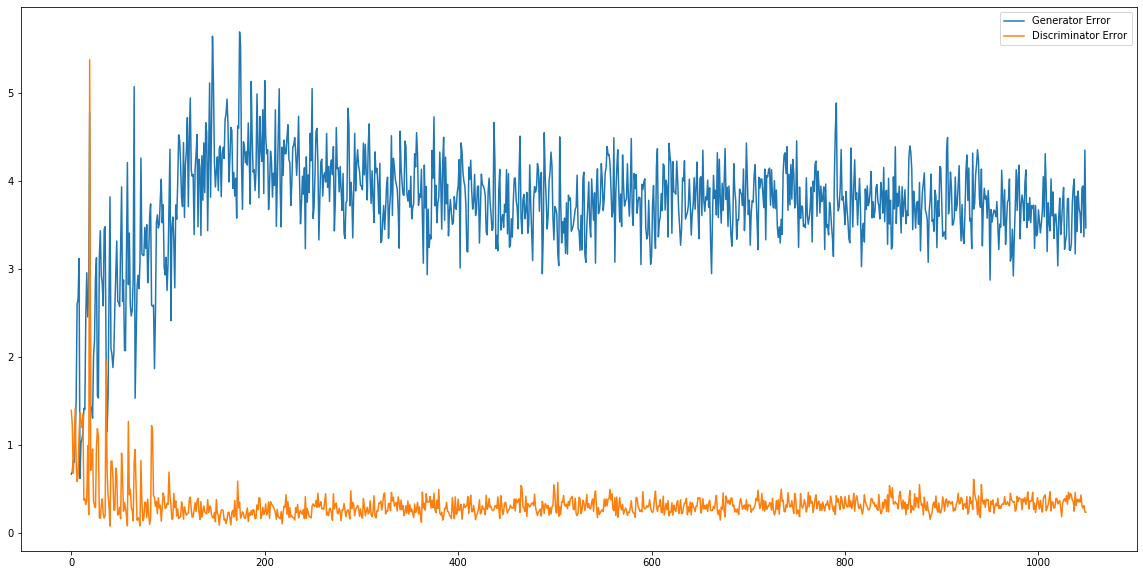

In [18]:
# Plot the discriminator & generator errors with training time

plt.figure(figsize=(20, 10))
plt.plot(g_err, label="Generator Error")
plt.plot(d_err, label="Discriminator Error")
plt.legend()
plt.show()

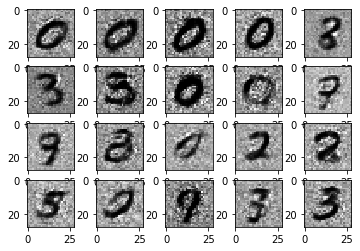

In [20]:
# Test the generator

test_images = gen(noise(20))
fig, axs = plt.subplots(4, 5)
for i in range(20):
    plot_img(test_images[i], axs, int(i/5), i%5)
plt.show()